In [1]:
%matplotlib inline

import os
while 'source' not in os.listdir():
    os.chdir('..')
os.chdir('source')

FORCE = False

import gpu

In [2]:
from util import getHashId


props={
    'path'          : 'data',
    'seed'          : 42,
    'split'         : 0.8,
    'test_split'    : 0.5,
    'control'       : True,
    'huntington'    : False,
    'left'          : False,
    'right'         : False,
    'threshold'     : 0.6,
    'binarize'      : True,
    'not_connected' : True,
    'single'        : None,
    'features'      : [],
    'features_vox'  : [],
    'radiomics'     : [
        #{'sp':'normalized','im':'t1','fe':['b25'],'fi':['roi','t1_mask']},
    ],
    'space'         : 'normalized',
    'radiomics_vox' : [
        {'im':'t1','fe':['k5_b25','k7_b25','k9_b25','k11_b25','k13_b25','k15_b25','k17_b25','k19_b25','k21_b25']},
    ],
    'rad_vox_norm'  : 'norm',
    'inps'          : ['coords'],
    'features_clin' : None,
    'outp'          : 'connectivity',
    'balance_data'  : False,
    'exclude'       : ['t1t2','normalized'],
    'include_warp'  : True,
    'collapse_max'  : False,
    'collapse_bin'  : False,
}

architecture={
    'activation'    : 'sigmoid',
    'layers'        : [1024,512,256,128],
    'loss'          : 'CCE',
    'learning_rate' : 0.001,
    'batch_size'    : 1000,
    'patience'      : 10,
    'dropout'       : 0.75,
}

HASHID, HASH = getHashId(architecture,props)
print(HASH)

sigmoid_1000_075_1024_512_256_128_0001_CCE_10_0_1_0_0_1_t1t2_normalized_e_n_e_0_1_coords_0_1_connectivity_data_norm_e_k5_b25_k7_b25_k9_b25_k11_b25_k13_b25_k15_b25_k17_b25_k19_b25_k21_b25_t1_0_42_n_normalized_08_05_06


In [3]:
from DataGenerator import DataGenerator

gen = DataGenerator(**props)
train, val, test = gen.getData()

print('train')
print(train[0].shape)
print(train[1].shape)
print('validation')
print(val[0].shape)
print(val[1].shape)
print('test')
print(test[0].shape)
print(test[1].shape)

train
(772408, 831)
(772408, 8)
validation
(101248, 831)
(101248, 8)
test
(98888, 831)
(98888, 8)


In [4]:
from Model import *
from tensorflow.keras.optimizers import Adam

path = props['path']+'/models'

stop = tf.keras.callbacks.EarlyStopping(
    monitor='val_loss',
    patience=architecture['patience'],
)
save = tf.keras.callbacks.ModelCheckpoint(
    filepath=path+'/{}.weights.h5'.format(HASHID),
    monitor='val_loss',
    mode='min',
    save_best_only=True,
    save_weights_only=True,
)

model = buildModel(train[0].shape[1], train[1].shape[1], activation=architecture['activation'], layers=architecture['layers'])

model.compile(loss=locals()[architecture['loss']], optimizer=Adam(learning_rate=architecture['learning_rate']), jit_compile=True, metrics=[STD,MAE])

model.summary()

Model: "FFN"


_________________________________________________________________


 Layer (type)                Output Shape              Param #   


 input_1 (InputLayer)        [(None, 831)]             0         


 dense (Dense)               (None, 1024)              851968    


 dense_1 (Dense)             (None, 512)               524800    


 dense_2 (Dense)             (None, 256)               131328    


 dense_3 (Dense)             (None, 128)               32896     


 dense_4 (Dense)             (None, 8)                 1032      


Total params: 1542024 (5.88 MB)


Trainable params: 1542024 (5.88 MB)


Non-trainable params: 0 (0.00 Byte)


_________________________________________________________________


In [5]:
import os
from util import pickleSave

if FORCE or not os.path.exists(path+'/{}.pkl'.format(HASHID)):
    history = model.fit(DataWrapper(train,architecture['batch_size']),
        validation_data=DataWrapper(val,architecture['batch_size'],False),
        epochs=10000,
        verbose=1,
        callbacks = [save,stop],
    )
    pickleSave(path+'/{}.pkl'.format(HASHID), history.history)

model.load_weights(path+'/{}.weights.h5'.format(HASHID))

Epoch 1/10000


  1/773 [..............................] - ETA: 14:20 - loss: 2.2988 - STD: 0.0503 - MAE: 0.2238

 15/773 [..............................] - ETA: 2s - loss: 1.4452 - STD: 0.1770 - MAE: 0.1530   

 30/773 [>.............................] - ETA: 2s - loss: 1.3916 - STD: 0.1872 - MAE: 0.1482

 45/773 [>.............................] - ETA: 2s - loss: 1.3689 - STD: 0.1884 - MAE: 0.1474

 60/773 [=>............................] - ETA: 2s - loss: 1.3547 - STD: 0.1890 - MAE: 0.1469

 76/773 [=>............................] - ETA: 2s - loss: 1.3468 - STD: 0.1899 - MAE: 0.1464

 92/773 [==>...........................] - ETA: 2s - loss: 1.3436 - STD: 0.1898 - MAE: 0.1465

107/773 [===>..........................] - ETA: 2s - loss: 1.3403 - STD: 0.1900 - MAE: 0.1464

118/773 [===>..........................] - ETA: 5s - loss: 1.3375 - STD: 0.1903 - MAE: 0.1462

132/773 [====>.........................] - ETA: 4s - loss: 1.3340 - STD: 0.1904 - MAE: 0.1460

146/773 [====>.........................] - ETA: 4s - loss: 1.3297 - STD: 0.1906 - MAE: 0.1458

162/773 [=====>........................] - ETA: 4s - loss: 1.3234 - STD: 0.1909 - MAE: 0.1454

179/773 [=====>........................] - ETA: 3s - loss: 1.3144 - STD: 0.1917 - MAE: 0.1448

195/773 [======>.......................] - ETA: 3s - loss: 1.3035 - STD: 0.1925 - MAE: 0.1442

211/773 [=======>......................] - ETA: 3s - loss: 1.2929 - STD: 0.1932 - MAE: 0.1436

227/773 [=======>......................] - ETA: 3s - loss: 1.2830 - STD: 0.1938 - MAE: 0.1431

244/773 [========>.....................] - ETA: 2s - loss: 1.2718 - STD: 0.1945 - MAE: 0.1425

261/773 [=========>....................] - ETA: 2s - loss: 1.2618 - STD: 0.1952 - MAE: 0.1420

278/773 [=========>....................] - ETA: 2s - loss: 1.2537 - STD: 0.1955 - MAE: 0.1417

295/773 [==========>...................] - ETA: 2s - loss: 1.2442 - STD: 0.1960 - MAE: 0.1412

312/773 [===========>..................] - ETA: 2s - loss: 1.2343 - STD: 0.1965 - MAE: 0.1408

330/773 [===========>..................] - ETA: 2s - loss: 1.2242 - STD: 0.1973 - MAE: 0.1401

348/773 [============>.................] - ETA: 2s - loss: 1.2150 - STD: 0.1980 - MAE: 0.1395

364/773 [=============>................] - ETA: 1s - loss: 1.2069 - STD: 0.1986 - MAE: 0.1390

380/773 [=============>................] - ETA: 1s - loss: 1.1988 - STD: 0.1992 - MAE: 0.1385

396/773 [==============>...............] - ETA: 1s - loss: 1.1900 - STD: 0.1999 - MAE: 0.1379

412/773 [==============>...............] - ETA: 1s - loss: 1.1822 - STD: 0.2005 - MAE: 0.1374

428/773 [===============>..............] - ETA: 1s - loss: 1.1742 - STD: 0.2010 - MAE: 0.1369

445/773 [================>.............] - ETA: 1s - loss: 1.1654 - STD: 0.2017 - MAE: 0.1363

461/773 [================>.............] - ETA: 1s - loss: 1.1574 - STD: 0.2024 - MAE: 0.1357

477/773 [=================>............] - ETA: 1s - loss: 1.1503 - STD: 0.2030 - MAE: 0.1351

494/773 [==================>...........] - ETA: 1s - loss: 1.1428 - STD: 0.2036 - MAE: 0.1346

510/773 [==================>...........] - ETA: 1s - loss: 1.1357 - STD: 0.2042 - MAE: 0.1341

526/773 [===================>..........] - ETA: 1s - loss: 1.1281 - STD: 0.2049 - MAE: 0.1335

542/773 [====================>.........] - ETA: 0s - loss: 1.1214 - STD: 0.2056 - MAE: 0.1330

558/773 [====================>.........] - ETA: 0s - loss: 1.1152 - STD: 0.2061 - MAE: 0.1325

574/773 [=====================>........] - ETA: 0s - loss: 1.1089 - STD: 0.2067 - MAE: 0.1320

591/773 [=====================>........] - ETA: 0s - loss: 1.1026 - STD: 0.2073 - MAE: 0.1315

608/773 [======================>.......] - ETA: 0s - loss: 1.0964 - STD: 0.2079 - MAE: 0.1310

624/773 [=======================>......] - ETA: 0s - loss: 1.0906 - STD: 0.2084 - MAE: 0.1306

640/773 [=======================>......] - ETA: 0s - loss: 1.0853 - STD: 0.2089 - MAE: 0.1301

656/773 [========================>.....] - ETA: 0s - loss: 1.0803 - STD: 0.2094 - MAE: 0.1297

673/773 [=========================>....] - ETA: 0s - loss: 1.0748 - STD: 0.2099 - MAE: 0.1293

690/773 [=========================>....] - ETA: 0s - loss: 1.0695 - STD: 0.2104 - MAE: 0.1289

706/773 [==========================>...] - ETA: 0s - loss: 1.0650 - STD: 0.2109 - MAE: 0.1285

721/773 [==========================>...] - ETA: 0s - loss: 1.0610 - STD: 0.2113 - MAE: 0.1281

738/773 [===========================>..] - ETA: 0s - loss: 1.0561 - STD: 0.2117 - MAE: 0.1277

755/773 [============================>.] - ETA: 0s - loss: 1.0516 - STD: 0.2122 - MAE: 0.1274

771/773 [============================>.] - ETA: 0s - loss: 1.0473 - STD: 0.2126 - MAE: 0.1270

773/773 [==============================] - 5s 5ms/step - loss: 1.0468 - STD: 0.2126 - MAE: 0.1270 - val_loss: 0.8684 - val_STD: 0.2300 - val_MAE: 0.1098


Epoch 2/10000


  1/773 [..............................] - ETA: 15s - loss: 0.8630 - STD: 0.2281 - MAE: 0.1128

 16/773 [..............................] - ETA: 2s - loss: 0.8469 - STD: 0.2327 - MAE: 0.1100 

 31/773 [>.............................] - ETA: 2s - loss: 0.8447 - STD: 0.2333 - MAE: 0.1095

 47/773 [>.............................] - ETA: 2s - loss: 0.8455 - STD: 0.2331 - MAE: 0.1096

 62/773 [=>............................] - ETA: 2s - loss: 0.8463 - STD: 0.2331 - MAE: 0.1097

 77/773 [=>............................] - ETA: 2s - loss: 0.8448 - STD: 0.2333 - MAE: 0.1096

 92/773 [==>...........................] - ETA: 2s - loss: 0.8446 - STD: 0.2330 - MAE: 0.1097

109/773 [===>..........................] - ETA: 2s - loss: 0.8393 - STD: 0.2335 - MAE: 0.1092

126/773 [===>..........................] - ETA: 2s - loss: 0.8407 - STD: 0.2335 - MAE: 0.1093

141/773 [====>.........................] - ETA: 2s - loss: 0.8406 - STD: 0.2334 - MAE: 0.1093

153/773 [====>.........................] - ETA: 2s - loss: 0.8395 - STD: 0.2335 - MAE: 0.1093

165/773 [=====>........................] - ETA: 2s - loss: 0.8394 - STD: 0.2335 - MAE: 0.1093

178/773 [=====>........................] - ETA: 2s - loss: 0.8381 - STD: 0.2336 - MAE: 0.1092

192/773 [======>.......................] - ETA: 2s - loss: 0.8372 - STD: 0.2337 - MAE: 0.1090

205/773 [======>.......................] - ETA: 2s - loss: 0.8362 - STD: 0.2337 - MAE: 0.1090

217/773 [=======>......................] - ETA: 1s - loss: 0.8353 - STD: 0.2338 - MAE: 0.1090

229/773 [=======>......................] - ETA: 1s - loss: 0.8344 - STD: 0.2339 - MAE: 0.1089

241/773 [========>.....................] - ETA: 1s - loss: 0.8335 - STD: 0.2339 - MAE: 0.1088

257/773 [========>.....................] - ETA: 1s - loss: 0.8328 - STD: 0.2341 - MAE: 0.1087

274/773 [=========>....................] - ETA: 1s - loss: 0.8317 - STD: 0.2342 - MAE: 0.1086

291/773 [==========>...................] - ETA: 1s - loss: 0.8310 - STD: 0.2343 - MAE: 0.1085

307/773 [==========>...................] - ETA: 1s - loss: 0.8302 - STD: 0.2343 - MAE: 0.1085

323/773 [===========>..................] - ETA: 1s - loss: 0.8288 - STD: 0.2344 - MAE: 0.1084

339/773 [============>.................] - ETA: 1s - loss: 0.8287 - STD: 0.2345 - MAE: 0.1084

355/773 [============>.................] - ETA: 1s - loss: 0.8272 - STD: 0.2345 - MAE: 0.1083

371/773 [=============>................] - ETA: 1s - loss: 0.8257 - STD: 0.2347 - MAE: 0.1082

388/773 [==============>...............] - ETA: 1s - loss: 0.8246 - STD: 0.2348 - MAE: 0.1081

405/773 [==============>...............] - ETA: 1s - loss: 0.8236 - STD: 0.2349 - MAE: 0.1080

422/773 [===============>..............] - ETA: 1s - loss: 0.8219 - STD: 0.2351 - MAE: 0.1078

438/773 [===============>..............] - ETA: 1s - loss: 0.8205 - STD: 0.2352 - MAE: 0.1077

455/773 [================>.............] - ETA: 1s - loss: 0.8193 - STD: 0.2352 - MAE: 0.1076

469/773 [=================>............] - ETA: 1s - loss: 0.8187 - STD: 0.2353 - MAE: 0.1075

481/773 [=================>............] - ETA: 1s - loss: 0.8182 - STD: 0.2354 - MAE: 0.1075

493/773 [==================>...........] - ETA: 0s - loss: 0.8173 - STD: 0.2355 - MAE: 0.1074

508/773 [==================>...........] - ETA: 0s - loss: 0.8165 - STD: 0.2356 - MAE: 0.1074

521/773 [===================>..........] - ETA: 0s - loss: 0.8156 - STD: 0.2356 - MAE: 0.1073

532/773 [===================>..........] - ETA: 0s - loss: 0.8149 - STD: 0.2357 - MAE: 0.1072

545/773 [====================>.........] - ETA: 0s - loss: 0.8146 - STD: 0.2358 - MAE: 0.1072

559/773 [====================>.........] - ETA: 0s - loss: 0.8137 - STD: 0.2358 - MAE: 0.1071

571/773 [=====================>........] - ETA: 0s - loss: 0.8128 - STD: 0.2359 - MAE: 0.1070

584/773 [=====================>........] - ETA: 0s - loss: 0.8120 - STD: 0.2360 - MAE: 0.1070

597/773 [======================>.......] - ETA: 0s - loss: 0.8112 - STD: 0.2360 - MAE: 0.1069

612/773 [======================>.......] - ETA: 0s - loss: 0.8106 - STD: 0.2361 - MAE: 0.1068

624/773 [=======================>......] - ETA: 0s - loss: 0.8098 - STD: 0.2361 - MAE: 0.1068

636/773 [=======================>......] - ETA: 0s - loss: 0.8093 - STD: 0.2362 - MAE: 0.1067

650/773 [========================>.....] - ETA: 0s - loss: 0.8085 - STD: 0.2363 - MAE: 0.1067

664/773 [========================>.....] - ETA: 0s - loss: 0.8076 - STD: 0.2364 - MAE: 0.1066

676/773 [=========================>....] - ETA: 0s - loss: 0.8072 - STD: 0.2364 - MAE: 0.1065

689/773 [=========================>....] - ETA: 0s - loss: 0.8061 - STD: 0.2365 - MAE: 0.1064

702/773 [==========================>...] - ETA: 0s - loss: 0.8054 - STD: 0.2366 - MAE: 0.1064

716/773 [==========================>...] - ETA: 0s - loss: 0.8045 - STD: 0.2367 - MAE: 0.1063

728/773 [===========================>..] - ETA: 0s - loss: 0.8039 - STD: 0.2367 - MAE: 0.1062

741/773 [===========================>..] - ETA: 0s - loss: 0.8032 - STD: 0.2368 - MAE: 0.1062

753/773 [============================>.] - ETA: 0s - loss: 0.8026 - STD: 0.2369 - MAE: 0.1061

767/773 [============================>.] - ETA: 0s - loss: 0.8020 - STD: 0.2369 - MAE: 0.1060

773/773 [==============================] - 3s 4ms/step - loss: 0.8019 - STD: 0.2370 - MAE: 0.1060 - val_loss: 0.8126 - val_STD: 0.2426 - val_MAE: 0.1013


Epoch 3/10000


  1/773 [..............................] - ETA: 16s - loss: 0.7614 - STD: 0.2443 - MAE: 0.1002

 16/773 [..............................] - ETA: 2s - loss: 0.7532 - STD: 0.2418 - MAE: 0.1013 

 30/773 [>.............................] - ETA: 2s - loss: 0.7590 - STD: 0.2419 - MAE: 0.1017

 45/773 [>.............................] - ETA: 2s - loss: 0.7586 - STD: 0.2415 - MAE: 0.1018

 61/773 [=>............................] - ETA: 2s - loss: 0.7567 - STD: 0.2414 - MAE: 0.1017

 77/773 [=>............................] - ETA: 2s - loss: 0.7544 - STD: 0.2417 - MAE: 0.1014

 94/773 [==>...........................] - ETA: 2s - loss: 0.7538 - STD: 0.2418 - MAE: 0.1014

112/773 [===>..........................] - ETA: 2s - loss: 0.7537 - STD: 0.2419 - MAE: 0.1013

130/773 [====>.........................] - ETA: 2s - loss: 0.7531 - STD: 0.2420 - MAE: 0.1012

146/773 [====>.........................] - ETA: 2s - loss: 0.7518 - STD: 0.2422 - MAE: 0.1011

164/773 [=====>........................] - ETA: 1s - loss: 0.7513 - STD: 0.2421 - MAE: 0.1011

180/773 [=====>........................] - ETA: 1s - loss: 0.7519 - STD: 0.2421 - MAE: 0.1011

197/773 [======>.......................] - ETA: 1s - loss: 0.7528 - STD: 0.2421 - MAE: 0.1012

215/773 [=======>......................] - ETA: 1s - loss: 0.7527 - STD: 0.2420 - MAE: 0.1012

231/773 [=======>......................] - ETA: 1s - loss: 0.7526 - STD: 0.2421 - MAE: 0.1012

245/773 [========>.....................] - ETA: 1s - loss: 0.7530 - STD: 0.2421 - MAE: 0.1012

261/773 [=========>....................] - ETA: 1s - loss: 0.7529 - STD: 0.2421 - MAE: 0.1012

278/773 [=========>....................] - ETA: 1s - loss: 0.7524 - STD: 0.2422 - MAE: 0.1012

295/773 [==========>...................] - ETA: 1s - loss: 0.7524 - STD: 0.2422 - MAE: 0.1012

312/773 [===========>..................] - ETA: 1s - loss: 0.7523 - STD: 0.2422 - MAE: 0.1012

329/773 [===========>..................] - ETA: 1s - loss: 0.7519 - STD: 0.2422 - MAE: 0.1011

346/773 [============>.................] - ETA: 1s - loss: 0.7511 - STD: 0.2423 - MAE: 0.1011

363/773 [=============>................] - ETA: 1s - loss: 0.7506 - STD: 0.2423 - MAE: 0.1011

380/773 [=============>................] - ETA: 1s - loss: 0.7508 - STD: 0.2423 - MAE: 0.1011

397/773 [==============>...............] - ETA: 1s - loss: 0.7504 - STD: 0.2423 - MAE: 0.1010

414/773 [===============>..............] - ETA: 1s - loss: 0.7499 - STD: 0.2423 - MAE: 0.1010

431/773 [===============>..............] - ETA: 1s - loss: 0.7497 - STD: 0.2424 - MAE: 0.1010

449/773 [================>.............] - ETA: 1s - loss: 0.7497 - STD: 0.2424 - MAE: 0.1010

465/773 [=================>............] - ETA: 0s - loss: 0.7495 - STD: 0.2424 - MAE: 0.1010

482/773 [=================>............] - ETA: 0s - loss: 0.7495 - STD: 0.2424 - MAE: 0.1010

498/773 [==================>...........] - ETA: 0s - loss: 0.7488 - STD: 0.2424 - MAE: 0.1010

514/773 [==================>...........] - ETA: 0s - loss: 0.7482 - STD: 0.2425 - MAE: 0.1009

530/773 [===================>..........] - ETA: 0s - loss: 0.7480 - STD: 0.2426 - MAE: 0.1008

546/773 [====================>.........] - ETA: 0s - loss: 0.7487 - STD: 0.2426 - MAE: 0.1009

563/773 [====================>.........] - ETA: 0s - loss: 0.7486 - STD: 0.2425 - MAE: 0.1009

580/773 [=====================>........] - ETA: 0s - loss: 0.7479 - STD: 0.2425 - MAE: 0.1009

597/773 [======================>.......] - ETA: 0s - loss: 0.7473 - STD: 0.2426 - MAE: 0.1008

614/773 [======================>.......] - ETA: 0s - loss: 0.7470 - STD: 0.2426 - MAE: 0.1008

631/773 [=======================>......] - ETA: 0s - loss: 0.7466 - STD: 0.2427 - MAE: 0.1007

649/773 [========================>.....] - ETA: 0s - loss: 0.7463 - STD: 0.2427 - MAE: 0.1007

667/773 [========================>.....] - ETA: 0s - loss: 0.7453 - STD: 0.2428 - MAE: 0.1006

684/773 [=========================>....] - ETA: 0s - loss: 0.7451 - STD: 0.2428 - MAE: 0.1006

701/773 [==========================>...] - ETA: 0s - loss: 0.7444 - STD: 0.2429 - MAE: 0.1005

719/773 [==========================>...] - ETA: 0s - loss: 0.7441 - STD: 0.2429 - MAE: 0.1005

737/773 [===========================>..] - ETA: 0s - loss: 0.7432 - STD: 0.2430 - MAE: 0.1004

753/773 [============================>.] - ETA: 0s - loss: 0.7429 - STD: 0.2430 - MAE: 0.1004

769/773 [============================>.] - ETA: 0s - loss: 0.7426 - STD: 0.2430 - MAE: 0.1004

773/773 [==============================] - 3s 3ms/step - loss: 0.7424 - STD: 0.2430 - MAE: 0.1004 - val_loss: 0.7468 - val_STD: 0.2392 - val_MAE: 0.1006


Epoch 4/10000


  1/773 [..............................] - ETA: 17s - loss: 0.7225 - STD: 0.2403 - MAE: 0.1003

 16/773 [..............................] - ETA: 2s - loss: 0.7222 - STD: 0.2442 - MAE: 0.0987 

 32/773 [>.............................] - ETA: 2s - loss: 0.7349 - STD: 0.2446 - MAE: 0.0992

 49/773 [>.............................] - ETA: 2s - loss: 0.7348 - STD: 0.2449 - MAE: 0.0992

 65/773 [=>............................] - ETA: 2s - loss: 0.7390 - STD: 0.2442 - MAE: 0.0997

 82/773 [==>...........................] - ETA: 2s - loss: 0.7363 - STD: 0.2443 - MAE: 0.0994

 95/773 [==>...........................] - ETA: 2s - loss: 0.7355 - STD: 0.2443 - MAE: 0.0994

108/773 [===>..........................] - ETA: 2s - loss: 0.7334 - STD: 0.2443 - MAE: 0.0993

121/773 [===>..........................] - ETA: 2s - loss: 0.7326 - STD: 0.2443 - MAE: 0.0993

134/773 [====>.........................] - ETA: 2s - loss: 0.7314 - STD: 0.2444 - MAE: 0.0992

146/773 [====>.........................] - ETA: 2s - loss: 0.7302 - STD: 0.2444 - MAE: 0.0991

158/773 [=====>........................] - ETA: 2s - loss: 0.7291 - STD: 0.2445 - MAE: 0.0990

173/773 [=====>........................] - ETA: 2s - loss: 0.7270 - STD: 0.2447 - MAE: 0.0988

189/773 [======>.......................] - ETA: 2s - loss: 0.7267 - STD: 0.2446 - MAE: 0.0988

203/773 [======>.......................] - ETA: 2s - loss: 0.7255 - STD: 0.2448 - MAE: 0.0987

215/773 [=======>......................] - ETA: 2s - loss: 0.7245 - STD: 0.2450 - MAE: 0.0985

229/773 [=======>......................] - ETA: 1s - loss: 0.7236 - STD: 0.2450 - MAE: 0.0985

242/773 [========>.....................] - ETA: 1s - loss: 0.7230 - STD: 0.2451 - MAE: 0.0984

255/773 [========>.....................] - ETA: 1s - loss: 0.7229 - STD: 0.2452 - MAE: 0.0984

268/773 [=========>....................] - ETA: 1s - loss: 0.7228 - STD: 0.2452 - MAE: 0.0983

281/773 [=========>....................] - ETA: 1s - loss: 0.7234 - STD: 0.2452 - MAE: 0.0984

294/773 [==========>...................] - ETA: 1s - loss: 0.7231 - STD: 0.2452 - MAE: 0.0984

307/773 [==========>...................] - ETA: 1s - loss: 0.7217 - STD: 0.2453 - MAE: 0.0982

319/773 [===========>..................] - ETA: 1s - loss: 0.7215 - STD: 0.2453 - MAE: 0.0982

331/773 [===========>..................] - ETA: 1s - loss: 0.7217 - STD: 0.2454 - MAE: 0.0982

343/773 [============>.................] - ETA: 1s - loss: 0.7217 - STD: 0.2454 - MAE: 0.0982

355/773 [============>.................] - ETA: 1s - loss: 0.7212 - STD: 0.2454 - MAE: 0.0981

367/773 [=============>................] - ETA: 1s - loss: 0.7211 - STD: 0.2454 - MAE: 0.0981

379/773 [=============>................] - ETA: 1s - loss: 0.7206 - STD: 0.2454 - MAE: 0.0981

392/773 [==============>...............] - ETA: 1s - loss: 0.7216 - STD: 0.2454 - MAE: 0.0981

405/773 [==============>...............] - ETA: 1s - loss: 0.7216 - STD: 0.2454 - MAE: 0.0982

418/773 [===============>..............] - ETA: 1s - loss: 0.7216 - STD: 0.2454 - MAE: 0.0981

430/773 [===============>..............] - ETA: 1s - loss: 0.7214 - STD: 0.2454 - MAE: 0.0981

442/773 [================>.............] - ETA: 1s - loss: 0.7212 - STD: 0.2454 - MAE: 0.0981

457/773 [================>.............] - ETA: 1s - loss: 0.7216 - STD: 0.2454 - MAE: 0.0982

470/773 [=================>............] - ETA: 1s - loss: 0.7221 - STD: 0.2454 - MAE: 0.0982

485/773 [=================>............] - ETA: 1s - loss: 0.7218 - STD: 0.2454 - MAE: 0.0982

498/773 [==================>...........] - ETA: 1s - loss: 0.7216 - STD: 0.2454 - MAE: 0.0982

511/773 [==================>...........] - ETA: 1s - loss: 0.7213 - STD: 0.2454 - MAE: 0.0982

524/773 [===================>..........] - ETA: 0s - loss: 0.7206 - STD: 0.2454 - MAE: 0.0981

537/773 [===================>..........] - ETA: 0s - loss: 0.7201 - STD: 0.2455 - MAE: 0.0981

549/773 [====================>.........] - ETA: 0s - loss: 0.7196 - STD: 0.2455 - MAE: 0.0980

562/773 [====================>.........] - ETA: 0s - loss: 0.7191 - STD: 0.2456 - MAE: 0.0980

575/773 [=====================>........] - ETA: 0s - loss: 0.7187 - STD: 0.2456 - MAE: 0.0979

589/773 [=====================>........] - ETA: 0s - loss: 0.7184 - STD: 0.2456 - MAE: 0.0979

605/773 [======================>.......] - ETA: 0s - loss: 0.7182 - STD: 0.2456 - MAE: 0.0979

617/773 [======================>.......] - ETA: 0s - loss: 0.7179 - STD: 0.2457 - MAE: 0.0979

629/773 [=======================>......] - ETA: 0s - loss: 0.7181 - STD: 0.2457 - MAE: 0.0979

641/773 [=======================>......] - ETA: 0s - loss: 0.7176 - STD: 0.2457 - MAE: 0.0978

655/773 [========================>.....] - ETA: 0s - loss: 0.7170 - STD: 0.2457 - MAE: 0.0978

667/773 [========================>.....] - ETA: 0s - loss: 0.7168 - STD: 0.2458 - MAE: 0.0977

682/773 [=========================>....] - ETA: 0s - loss: 0.7168 - STD: 0.2458 - MAE: 0.0977

699/773 [==========================>...] - ETA: 0s - loss: 0.7165 - STD: 0.2458 - MAE: 0.0977

716/773 [==========================>...] - ETA: 0s - loss: 0.7159 - STD: 0.2459 - MAE: 0.0976

733/773 [===========================>..] - ETA: 0s - loss: 0.7154 - STD: 0.2459 - MAE: 0.0976

751/773 [============================>.] - ETA: 0s - loss: 0.7149 - STD: 0.2460 - MAE: 0.0975

767/773 [============================>.] - ETA: 0s - loss: 0.7146 - STD: 0.2460 - MAE: 0.0975

773/773 [==============================] - 3s 4ms/step - loss: 0.7146 - STD: 0.2460 - MAE: 0.0975 - val_loss: 0.7525 - val_STD: 0.2534 - val_MAE: 0.0939


Epoch 5/10000


  1/773 [..............................] - ETA: 16s - loss: 0.6981 - STD: 0.2552 - MAE: 0.0900

 18/773 [..............................] - ETA: 2s - loss: 0.6875 - STD: 0.2476 - MAE: 0.0953 

 35/773 [>.............................] - ETA: 2s - loss: 0.6896 - STD: 0.2484 - MAE: 0.0950

 50/773 [>.............................] - ETA: 2s - loss: 0.6954 - STD: 0.2481 - MAE: 0.0955

 66/773 [=>............................] - ETA: 2s - loss: 0.6961 - STD: 0.2477 - MAE: 0.0958

 81/773 [==>...........................] - ETA: 2s - loss: 0.6984 - STD: 0.2476 - MAE: 0.0959

 98/773 [==>...........................] - ETA: 2s - loss: 0.7003 - STD: 0.2475 - MAE: 0.0961

116/773 [===>..........................] - ETA: 2s - loss: 0.6990 - STD: 0.2476 - MAE: 0.0960

132/773 [====>.........................] - ETA: 2s - loss: 0.6979 - STD: 0.2475 - MAE: 0.0959

148/773 [====>.........................] - ETA: 1s - loss: 0.6981 - STD: 0.2475 - MAE: 0.0960

164/773 [=====>........................] - ETA: 1s - loss: 0.6980 - STD: 0.2476 - MAE: 0.0959

180/773 [=====>........................] - ETA: 1s - loss: 0.6975 - STD: 0.2476 - MAE: 0.0959

194/773 [======>.......................] - ETA: 1s - loss: 0.6975 - STD: 0.2477 - MAE: 0.0958

211/773 [=======>......................] - ETA: 1s - loss: 0.6965 - STD: 0.2478 - MAE: 0.0957

228/773 [=======>......................] - ETA: 1s - loss: 0.6961 - STD: 0.2478 - MAE: 0.0957

244/773 [========>.....................] - ETA: 1s - loss: 0.6960 - STD: 0.2479 - MAE: 0.0957

261/773 [=========>....................] - ETA: 1s - loss: 0.6954 - STD: 0.2479 - MAE: 0.0956

277/773 [=========>....................] - ETA: 1s - loss: 0.6944 - STD: 0.2480 - MAE: 0.0955

293/773 [==========>...................] - ETA: 1s - loss: 0.6941 - STD: 0.2480 - MAE: 0.0955

309/773 [==========>...................] - ETA: 1s - loss: 0.6933 - STD: 0.2480 - MAE: 0.0954

325/773 [===========>..................] - ETA: 1s - loss: 0.6928 - STD: 0.2480 - MAE: 0.0954

340/773 [============>.................] - ETA: 1s - loss: 0.6928 - STD: 0.2481 - MAE: 0.0953

357/773 [============>.................] - ETA: 1s - loss: 0.6933 - STD: 0.2481 - MAE: 0.0954

374/773 [=============>................] - ETA: 1s - loss: 0.6925 - STD: 0.2481 - MAE: 0.0953

389/773 [==============>...............] - ETA: 1s - loss: 0.6922 - STD: 0.2482 - MAE: 0.0953

406/773 [==============>...............] - ETA: 1s - loss: 0.6921 - STD: 0.2482 - MAE: 0.0953

419/773 [===============>..............] - ETA: 1s - loss: 0.6932 - STD: 0.2482 - MAE: 0.0953

435/773 [===============>..............] - ETA: 1s - loss: 0.6934 - STD: 0.2482 - MAE: 0.0953

451/773 [================>.............] - ETA: 1s - loss: 0.6924 - STD: 0.2483 - MAE: 0.0953

469/773 [=================>............] - ETA: 0s - loss: 0.6916 - STD: 0.2483 - MAE: 0.0952

487/773 [=================>............] - ETA: 0s - loss: 0.6919 - STD: 0.2483 - MAE: 0.0952

503/773 [==================>...........] - ETA: 0s - loss: 0.6916 - STD: 0.2484 - MAE: 0.0952

517/773 [===================>..........] - ETA: 0s - loss: 0.6912 - STD: 0.2484 - MAE: 0.0951

532/773 [===================>..........] - ETA: 0s - loss: 0.6906 - STD: 0.2484 - MAE: 0.0951

548/773 [====================>.........] - ETA: 0s - loss: 0.6906 - STD: 0.2484 - MAE: 0.0951

565/773 [====================>.........] - ETA: 0s - loss: 0.6901 - STD: 0.2485 - MAE: 0.0950

581/773 [=====================>........] - ETA: 0s - loss: 0.6899 - STD: 0.2485 - MAE: 0.0950

597/773 [======================>.......] - ETA: 0s - loss: 0.6895 - STD: 0.2486 - MAE: 0.0949

614/773 [======================>.......] - ETA: 0s - loss: 0.6893 - STD: 0.2486 - MAE: 0.0949

630/773 [=======================>......] - ETA: 0s - loss: 0.6895 - STD: 0.2486 - MAE: 0.0949

647/773 [========================>.....] - ETA: 0s - loss: 0.6892 - STD: 0.2486 - MAE: 0.0949

665/773 [========================>.....] - ETA: 0s - loss: 0.6888 - STD: 0.2486 - MAE: 0.0949

683/773 [=========================>....] - ETA: 0s - loss: 0.6882 - STD: 0.2487 - MAE: 0.0948

700/773 [==========================>...] - ETA: 0s - loss: 0.6878 - STD: 0.2487 - MAE: 0.0948

717/773 [==========================>...] - ETA: 0s - loss: 0.6875 - STD: 0.2488 - MAE: 0.0947

733/773 [===========================>..] - ETA: 0s - loss: 0.6873 - STD: 0.2488 - MAE: 0.0947

750/773 [============================>.] - ETA: 0s - loss: 0.6868 - STD: 0.2488 - MAE: 0.0947

766/773 [============================>.] - ETA: 0s - loss: 0.6866 - STD: 0.2489 - MAE: 0.0946

773/773 [==============================] - 3s 3ms/step - loss: 0.6866 - STD: 0.2489 - MAE: 0.0946 - val_loss: 0.7651 - val_STD: 0.2513 - val_MAE: 0.0950


Epoch 6/10000


  1/773 [..............................] - ETA: 14s - loss: 0.6827 - STD: 0.2539 - MAE: 0.0915

 17/773 [..............................] - ETA: 2s - loss: 0.6838 - STD: 0.2498 - MAE: 0.0941 

 33/773 [>.............................] - ETA: 2s - loss: 0.6727 - STD: 0.2500 - MAE: 0.0932

 47/773 [>.............................] - ETA: 2s - loss: 0.6748 - STD: 0.2497 - MAE: 0.0936

 60/773 [=>............................] - ETA: 2s - loss: 0.6709 - STD: 0.2498 - MAE: 0.0934

 75/773 [=>............................] - ETA: 2s - loss: 0.6694 - STD: 0.2503 - MAE: 0.0930

 92/773 [==>...........................] - ETA: 2s - loss: 0.6681 - STD: 0.2504 - MAE: 0.0929

110/773 [===>..........................] - ETA: 2s - loss: 0.6692 - STD: 0.2506 - MAE: 0.0928

122/773 [===>..........................] - ETA: 2s - loss: 0.6692 - STD: 0.2505 - MAE: 0.0929

138/773 [====>.........................] - ETA: 2s - loss: 0.6714 - STD: 0.2504 - MAE: 0.0931

155/773 [=====>........................] - ETA: 2s - loss: 0.6702 - STD: 0.2505 - MAE: 0.0930

172/773 [=====>........................] - ETA: 1s - loss: 0.6696 - STD: 0.2505 - MAE: 0.0929

189/773 [======>.......................] - ETA: 1s - loss: 0.6688 - STD: 0.2505 - MAE: 0.0929

204/773 [======>.......................] - ETA: 1s - loss: 0.6681 - STD: 0.2506 - MAE: 0.0928

217/773 [=======>......................] - ETA: 1s - loss: 0.6690 - STD: 0.2506 - MAE: 0.0929

231/773 [=======>......................] - ETA: 1s - loss: 0.6689 - STD: 0.2506 - MAE: 0.0928

245/773 [========>.....................] - ETA: 1s - loss: 0.6699 - STD: 0.2506 - MAE: 0.0929

258/773 [=========>....................] - ETA: 1s - loss: 0.6706 - STD: 0.2506 - MAE: 0.0929

272/773 [=========>....................] - ETA: 1s - loss: 0.6711 - STD: 0.2506 - MAE: 0.0930

287/773 [==========>...................] - ETA: 1s - loss: 0.6717 - STD: 0.2505 - MAE: 0.0931

301/773 [==========>...................] - ETA: 1s - loss: 0.6724 - STD: 0.2504 - MAE: 0.0931

314/773 [===========>..................] - ETA: 1s - loss: 0.6719 - STD: 0.2505 - MAE: 0.0931

327/773 [===========>..................] - ETA: 1s - loss: 0.6713 - STD: 0.2505 - MAE: 0.0931

339/773 [============>.................] - ETA: 1s - loss: 0.6711 - STD: 0.2505 - MAE: 0.0930

351/773 [============>.................] - ETA: 1s - loss: 0.6708 - STD: 0.2505 - MAE: 0.0930

363/773 [=============>................] - ETA: 1s - loss: 0.6705 - STD: 0.2506 - MAE: 0.0929

375/773 [=============>................] - ETA: 1s - loss: 0.6700 - STD: 0.2506 - MAE: 0.0929

387/773 [==============>...............] - ETA: 1s - loss: 0.6696 - STD: 0.2507 - MAE: 0.0929

400/773 [==============>...............] - ETA: 1s - loss: 0.6691 - STD: 0.2507 - MAE: 0.0928

413/773 [===============>..............] - ETA: 1s - loss: 0.6693 - STD: 0.2507 - MAE: 0.0928

427/773 [===============>..............] - ETA: 1s - loss: 0.6690 - STD: 0.2507 - MAE: 0.0928

440/773 [================>.............] - ETA: 1s - loss: 0.6694 - STD: 0.2507 - MAE: 0.0929

453/773 [================>.............] - ETA: 1s - loss: 0.6692 - STD: 0.2507 - MAE: 0.0928

465/773 [=================>............] - ETA: 1s - loss: 0.6695 - STD: 0.2507 - MAE: 0.0928

477/773 [=================>............] - ETA: 1s - loss: 0.6696 - STD: 0.2508 - MAE: 0.0928

491/773 [==================>...........] - ETA: 1s - loss: 0.6695 - STD: 0.2508 - MAE: 0.0928

503/773 [==================>...........] - ETA: 1s - loss: 0.6694 - STD: 0.2508 - MAE: 0.0928

516/773 [===================>..........] - ETA: 0s - loss: 0.6692 - STD: 0.2508 - MAE: 0.0928

529/773 [===================>..........] - ETA: 0s - loss: 0.6690 - STD: 0.2508 - MAE: 0.0927

542/773 [====================>.........] - ETA: 0s - loss: 0.6687 - STD: 0.2508 - MAE: 0.0927

555/773 [====================>.........] - ETA: 0s - loss: 0.6683 - STD: 0.2508 - MAE: 0.0927

567/773 [=====================>........] - ETA: 0s - loss: 0.6683 - STD: 0.2509 - MAE: 0.0927

579/773 [=====================>........] - ETA: 0s - loss: 0.6683 - STD: 0.2509 - MAE: 0.0927

591/773 [=====================>........] - ETA: 0s - loss: 0.6680 - STD: 0.2509 - MAE: 0.0926

604/773 [======================>.......] - ETA: 0s - loss: 0.6678 - STD: 0.2509 - MAE: 0.0926

616/773 [======================>.......] - ETA: 0s - loss: 0.6679 - STD: 0.2509 - MAE: 0.0926

628/773 [=======================>......] - ETA: 0s - loss: 0.6679 - STD: 0.2509 - MAE: 0.0926

640/773 [=======================>......] - ETA: 0s - loss: 0.6678 - STD: 0.2509 - MAE: 0.0926

652/773 [========================>.....] - ETA: 0s - loss: 0.6676 - STD: 0.2509 - MAE: 0.0926

665/773 [========================>.....] - ETA: 0s - loss: 0.6673 - STD: 0.2509 - MAE: 0.0926

678/773 [=========================>....] - ETA: 0s - loss: 0.6670 - STD: 0.2509 - MAE: 0.0926

693/773 [=========================>....] - ETA: 0s - loss: 0.6667 - STD: 0.2510 - MAE: 0.0925

707/773 [==========================>...] - ETA: 0s - loss: 0.6666 - STD: 0.2510 - MAE: 0.0925

722/773 [===========================>..] - ETA: 0s - loss: 0.6667 - STD: 0.2510 - MAE: 0.0925

737/773 [===========================>..] - ETA: 0s - loss: 0.6669 - STD: 0.2510 - MAE: 0.0925

753/773 [============================>.] - ETA: 0s - loss: 0.6669 - STD: 0.2510 - MAE: 0.0925

768/773 [============================>.] - ETA: 0s - loss: 0.6666 - STD: 0.2510 - MAE: 0.0925

773/773 [==============================] - 3s 4ms/step - loss: 0.6665 - STD: 0.2511 - MAE: 0.0925 - val_loss: 0.7257 - val_STD: 0.2460 - val_MAE: 0.0969


Epoch 7/10000


  1/773 [..............................] - ETA: 19s - loss: 0.7063 - STD: 0.2476 - MAE: 0.0963

 13/773 [..............................] - ETA: 3s - loss: 0.6580 - STD: 0.2530 - MAE: 0.0910 

 29/773 [>.............................] - ETA: 2s - loss: 0.6577 - STD: 0.2516 - MAE: 0.0917

 47/773 [>.............................] - ETA: 2s - loss: 0.6536 - STD: 0.2517 - MAE: 0.0915

 63/773 [=>............................] - ETA: 2s - loss: 0.6539 - STD: 0.2523 - MAE: 0.0912

 79/773 [==>...........................] - ETA: 2s - loss: 0.6552 - STD: 0.2521 - MAE: 0.0913

 96/773 [==>...........................] - ETA: 2s - loss: 0.6530 - STD: 0.2522 - MAE: 0.0912

113/773 [===>..........................] - ETA: 2s - loss: 0.6536 - STD: 0.2521 - MAE: 0.0913

129/773 [====>.........................] - ETA: 2s - loss: 0.6530 - STD: 0.2522 - MAE: 0.0912

146/773 [====>.........................] - ETA: 1s - loss: 0.6544 - STD: 0.2521 - MAE: 0.0913

163/773 [=====>........................] - ETA: 1s - loss: 0.6556 - STD: 0.2521 - MAE: 0.0914

180/773 [=====>........................] - ETA: 1s - loss: 0.6556 - STD: 0.2521 - MAE: 0.0914

197/773 [======>.......................] - ETA: 1s - loss: 0.6552 - STD: 0.2521 - MAE: 0.0914

213/773 [=======>......................] - ETA: 1s - loss: 0.6557 - STD: 0.2520 - MAE: 0.0915

230/773 [=======>......................] - ETA: 1s - loss: 0.6548 - STD: 0.2521 - MAE: 0.0914

247/773 [========>.....................] - ETA: 1s - loss: 0.6562 - STD: 0.2521 - MAE: 0.0915

264/773 [=========>....................] - ETA: 1s - loss: 0.6566 - STD: 0.2521 - MAE: 0.0915

281/773 [=========>....................] - ETA: 1s - loss: 0.6555 - STD: 0.2522 - MAE: 0.0914

299/773 [==========>...................] - ETA: 1s - loss: 0.6546 - STD: 0.2522 - MAE: 0.0913

317/773 [===========>..................] - ETA: 1s - loss: 0.6542 - STD: 0.2523 - MAE: 0.0912

334/773 [===========>..................] - ETA: 1s - loss: 0.6539 - STD: 0.2523 - MAE: 0.0912

352/773 [============>.................] - ETA: 1s - loss: 0.6539 - STD: 0.2523 - MAE: 0.0912

369/773 [=============>................] - ETA: 1s - loss: 0.6532 - STD: 0.2524 - MAE: 0.0911

386/773 [=============>................] - ETA: 1s - loss: 0.6529 - STD: 0.2523 - MAE: 0.0911

403/773 [==============>...............] - ETA: 1s - loss: 0.6526 - STD: 0.2524 - MAE: 0.0911

420/773 [===============>..............] - ETA: 1s - loss: 0.6523 - STD: 0.2524 - MAE: 0.0910

437/773 [===============>..............] - ETA: 1s - loss: 0.6518 - STD: 0.2524 - MAE: 0.0910

453/773 [================>.............] - ETA: 0s - loss: 0.6516 - STD: 0.2525 - MAE: 0.0909

470/773 [=================>............] - ETA: 0s - loss: 0.6512 - STD: 0.2525 - MAE: 0.0909

487/773 [=================>............] - ETA: 0s - loss: 0.6508 - STD: 0.2525 - MAE: 0.0909

504/773 [==================>...........] - ETA: 0s - loss: 0.6508 - STD: 0.2526 - MAE: 0.0909

521/773 [===================>..........] - ETA: 0s - loss: 0.6514 - STD: 0.2526 - MAE: 0.0909

538/773 [===================>..........] - ETA: 0s - loss: 0.6515 - STD: 0.2525 - MAE: 0.0909

555/773 [====================>.........] - ETA: 0s - loss: 0.6514 - STD: 0.2526 - MAE: 0.0909

571/773 [=====================>........] - ETA: 0s - loss: 0.6510 - STD: 0.2526 - MAE: 0.0909

587/773 [=====================>........] - ETA: 0s - loss: 0.6503 - STD: 0.2526 - MAE: 0.0908

604/773 [======================>.......] - ETA: 0s - loss: 0.6498 - STD: 0.2527 - MAE: 0.0907

619/773 [=======================>......] - ETA: 0s - loss: 0.6497 - STD: 0.2527 - MAE: 0.0907

635/773 [=======================>......] - ETA: 0s - loss: 0.6499 - STD: 0.2527 - MAE: 0.0907

651/773 [========================>.....] - ETA: 0s - loss: 0.6497 - STD: 0.2527 - MAE: 0.0907

668/773 [========================>.....] - ETA: 0s - loss: 0.6495 - STD: 0.2527 - MAE: 0.0907

684/773 [=========================>....] - ETA: 0s - loss: 0.6494 - STD: 0.2527 - MAE: 0.0907

701/773 [==========================>...] - ETA: 0s - loss: 0.6491 - STD: 0.2528 - MAE: 0.0907

718/773 [==========================>...] - ETA: 0s - loss: 0.6488 - STD: 0.2528 - MAE: 0.0906

735/773 [===========================>..] - ETA: 0s - loss: 0.6487 - STD: 0.2528 - MAE: 0.0906

753/773 [============================>.] - ETA: 0s - loss: 0.6487 - STD: 0.2528 - MAE: 0.0906

770/773 [============================>.] - ETA: 0s - loss: 0.6480 - STD: 0.2529 - MAE: 0.0905

773/773 [==============================] - 3s 3ms/step - loss: 0.6479 - STD: 0.2529 - MAE: 0.0905 - val_loss: 0.7628 - val_STD: 0.2517 - val_MAE: 0.0950


Epoch 8/10000


  1/773 [..............................] - ETA: 15s - loss: 0.6303 - STD: 0.2519 - MAE: 0.0897

 17/773 [..............................] - ETA: 2s - loss: 0.6483 - STD: 0.2536 - MAE: 0.0902 

 33/773 [>.............................] - ETA: 2s - loss: 0.6374 - STD: 0.2537 - MAE: 0.0894

 48/773 [>.............................] - ETA: 2s - loss: 0.6334 - STD: 0.2539 - MAE: 0.0890

 65/773 [=>............................] - ETA: 2s - loss: 0.6347 - STD: 0.2540 - MAE: 0.0891

 82/773 [==>...........................] - ETA: 2s - loss: 0.6353 - STD: 0.2542 - MAE: 0.0890

 98/773 [==>...........................] - ETA: 2s - loss: 0.6338 - STD: 0.2545 - MAE: 0.0888

114/773 [===>..........................] - ETA: 2s - loss: 0.6327 - STD: 0.2545 - MAE: 0.0887

130/773 [====>.........................] - ETA: 2s - loss: 0.6317 - STD: 0.2545 - MAE: 0.0887

146/773 [====>.........................] - ETA: 2s - loss: 0.6304 - STD: 0.2546 - MAE: 0.0885

163/773 [=====>........................] - ETA: 1s - loss: 0.6317 - STD: 0.2547 - MAE: 0.0886

180/773 [=====>........................] - ETA: 1s - loss: 0.6321 - STD: 0.2549 - MAE: 0.0885

196/773 [======>.......................] - ETA: 1s - loss: 0.6324 - STD: 0.2548 - MAE: 0.0886

212/773 [=======>......................] - ETA: 1s - loss: 0.6330 - STD: 0.2548 - MAE: 0.0886

226/773 [=======>......................] - ETA: 1s - loss: 0.6342 - STD: 0.2546 - MAE: 0.0888

240/773 [========>.....................] - ETA: 1s - loss: 0.6340 - STD: 0.2546 - MAE: 0.0888

254/773 [========>.....................] - ETA: 1s - loss: 0.6332 - STD: 0.2546 - MAE: 0.0888

270/773 [=========>....................] - ETA: 1s - loss: 0.6322 - STD: 0.2547 - MAE: 0.0887

286/773 [==========>...................] - ETA: 1s - loss: 0.6318 - STD: 0.2547 - MAE: 0.0886

303/773 [==========>...................] - ETA: 1s - loss: 0.6318 - STD: 0.2547 - MAE: 0.0887

319/773 [===========>..................] - ETA: 1s - loss: 0.6324 - STD: 0.2546 - MAE: 0.0887

335/773 [============>.................] - ETA: 1s - loss: 0.6324 - STD: 0.2546 - MAE: 0.0887

352/773 [============>.................] - ETA: 1s - loss: 0.6323 - STD: 0.2546 - MAE: 0.0887

369/773 [=============>................] - ETA: 1s - loss: 0.6319 - STD: 0.2546 - MAE: 0.0887

386/773 [=============>................] - ETA: 1s - loss: 0.6317 - STD: 0.2546 - MAE: 0.0887

403/773 [==============>...............] - ETA: 1s - loss: 0.6312 - STD: 0.2547 - MAE: 0.0886

421/773 [===============>..............] - ETA: 1s - loss: 0.6310 - STD: 0.2547 - MAE: 0.0886

438/773 [===============>..............] - ETA: 1s - loss: 0.6301 - STD: 0.2548 - MAE: 0.0885

456/773 [================>.............] - ETA: 1s - loss: 0.6299 - STD: 0.2548 - MAE: 0.0885

473/773 [=================>............] - ETA: 0s - loss: 0.6299 - STD: 0.2548 - MAE: 0.0885

490/773 [==================>...........] - ETA: 0s - loss: 0.6298 - STD: 0.2549 - MAE: 0.0884

507/773 [==================>...........] - ETA: 0s - loss: 0.6298 - STD: 0.2549 - MAE: 0.0884

523/773 [===================>..........] - ETA: 0s - loss: 0.6293 - STD: 0.2549 - MAE: 0.0884

541/773 [===================>..........] - ETA: 0s - loss: 0.6292 - STD: 0.2549 - MAE: 0.0884

557/773 [====================>.........] - ETA: 0s - loss: 0.6291 - STD: 0.2550 - MAE: 0.0883

574/773 [=====================>........] - ETA: 0s - loss: 0.6289 - STD: 0.2550 - MAE: 0.0883

591/773 [=====================>........] - ETA: 0s - loss: 0.6290 - STD: 0.2550 - MAE: 0.0883

608/773 [======================>.......] - ETA: 0s - loss: 0.6288 - STD: 0.2550 - MAE: 0.0883

625/773 [=======================>......] - ETA: 0s - loss: 0.6289 - STD: 0.2550 - MAE: 0.0883

642/773 [=======================>......] - ETA: 0s - loss: 0.6290 - STD: 0.2550 - MAE: 0.0883

659/773 [========================>.....] - ETA: 0s - loss: 0.6286 - STD: 0.2550 - MAE: 0.0883

676/773 [=========================>....] - ETA: 0s - loss: 0.6285 - STD: 0.2550 - MAE: 0.0883

693/773 [=========================>....] - ETA: 0s - loss: 0.6285 - STD: 0.2551 - MAE: 0.0882

710/773 [==========================>...] - ETA: 0s - loss: 0.6282 - STD: 0.2551 - MAE: 0.0882

725/773 [===========================>..] - ETA: 0s - loss: 0.6284 - STD: 0.2551 - MAE: 0.0882

741/773 [===========================>..] - ETA: 0s - loss: 0.6287 - STD: 0.2551 - MAE: 0.0882

757/773 [============================>.] - ETA: 0s - loss: 0.6285 - STD: 0.2551 - MAE: 0.0882

773/773 [==============================] - ETA: 0s - loss: 0.6284 - STD: 0.2551 - MAE: 0.0882

773/773 [==============================] - 3s 3ms/step - loss: 0.6284 - STD: 0.2551 - MAE: 0.0882 - val_loss: 0.7506 - val_STD: 0.2492 - val_MAE: 0.0970


Epoch 9/10000


  1/773 [..............................] - ETA: 16s - loss: 0.6226 - STD: 0.2520 - MAE: 0.0898

 13/773 [..............................] - ETA: 3s - loss: 0.6335 - STD: 0.2556 - MAE: 0.0883 

 25/773 [..............................] - ETA: 3s - loss: 0.6259 - STD: 0.2556 - MAE: 0.0879

 37/773 [>.............................] - ETA: 3s - loss: 0.6210 - STD: 0.2560 - MAE: 0.0873

 52/773 [=>............................] - ETA: 2s - loss: 0.6178 - STD: 0.2558 - MAE: 0.0873

 65/773 [=>............................] - ETA: 2s - loss: 0.6205 - STD: 0.2560 - MAE: 0.0873

 79/773 [==>...........................] - ETA: 2s - loss: 0.6208 - STD: 0.2558 - MAE: 0.0874

 95/773 [==>...........................] - ETA: 2s - loss: 0.6203 - STD: 0.2560 - MAE: 0.0872

111/773 [===>..........................] - ETA: 2s - loss: 0.6200 - STD: 0.2559 - MAE: 0.0872

126/773 [===>..........................] - ETA: 2s - loss: 0.6191 - STD: 0.2559 - MAE: 0.0872

138/773 [====>.........................] - ETA: 2s - loss: 0.6176 - STD: 0.2560 - MAE: 0.0871

154/773 [====>.........................] - ETA: 2s - loss: 0.6169 - STD: 0.2560 - MAE: 0.0870

169/773 [=====>........................] - ETA: 2s - loss: 0.6174 - STD: 0.2560 - MAE: 0.0871

183/773 [======>.......................] - ETA: 2s - loss: 0.6173 - STD: 0.2561 - MAE: 0.0870

194/773 [======>.......................] - ETA: 2s - loss: 0.6164 - STD: 0.2561 - MAE: 0.0869

208/773 [=======>......................] - ETA: 2s - loss: 0.6156 - STD: 0.2562 - MAE: 0.0868

224/773 [=======>......................] - ETA: 2s - loss: 0.6159 - STD: 0.2562 - MAE: 0.0869

240/773 [========>.....................] - ETA: 1s - loss: 0.6157 - STD: 0.2562 - MAE: 0.0868

257/773 [========>.....................] - ETA: 1s - loss: 0.6148 - STD: 0.2562 - MAE: 0.0868

273/773 [=========>....................] - ETA: 1s - loss: 0.6145 - STD: 0.2563 - MAE: 0.0867

290/773 [==========>...................] - ETA: 1s - loss: 0.6152 - STD: 0.2564 - MAE: 0.0868

306/773 [==========>...................] - ETA: 1s - loss: 0.6148 - STD: 0.2564 - MAE: 0.0867

321/773 [===========>..................] - ETA: 1s - loss: 0.6146 - STD: 0.2564 - MAE: 0.0867

336/773 [============>.................] - ETA: 1s - loss: 0.6151 - STD: 0.2564 - MAE: 0.0867

351/773 [============>.................] - ETA: 1s - loss: 0.6154 - STD: 0.2564 - MAE: 0.0867

367/773 [=============>................] - ETA: 1s - loss: 0.6156 - STD: 0.2564 - MAE: 0.0868

383/773 [=============>................] - ETA: 1s - loss: 0.6149 - STD: 0.2564 - MAE: 0.0867

400/773 [==============>...............] - ETA: 1s - loss: 0.6142 - STD: 0.2565 - MAE: 0.0866

417/773 [===============>..............] - ETA: 1s - loss: 0.6136 - STD: 0.2565 - MAE: 0.0866

434/773 [===============>..............] - ETA: 1s - loss: 0.6134 - STD: 0.2566 - MAE: 0.0866

451/773 [================>.............] - ETA: 1s - loss: 0.6133 - STD: 0.2566 - MAE: 0.0865

467/773 [=================>............] - ETA: 1s - loss: 0.6127 - STD: 0.2567 - MAE: 0.0865

484/773 [=================>............] - ETA: 0s - loss: 0.6124 - STD: 0.2567 - MAE: 0.0864

501/773 [==================>...........] - ETA: 0s - loss: 0.6124 - STD: 0.2567 - MAE: 0.0864

519/773 [===================>..........] - ETA: 0s - loss: 0.6128 - STD: 0.2567 - MAE: 0.0865

537/773 [===================>..........] - ETA: 0s - loss: 0.6125 - STD: 0.2567 - MAE: 0.0864

555/773 [====================>.........] - ETA: 0s - loss: 0.6128 - STD: 0.2567 - MAE: 0.0864

572/773 [=====================>........] - ETA: 0s - loss: 0.6130 - STD: 0.2568 - MAE: 0.0864

589/773 [=====================>........] - ETA: 0s - loss: 0.6128 - STD: 0.2568 - MAE: 0.0864

607/773 [======================>.......] - ETA: 0s - loss: 0.6125 - STD: 0.2568 - MAE: 0.0864

624/773 [=======================>......] - ETA: 0s - loss: 0.6117 - STD: 0.2568 - MAE: 0.0863

641/773 [=======================>......] - ETA: 0s - loss: 0.6114 - STD: 0.2568 - MAE: 0.0863

658/773 [========================>.....] - ETA: 0s - loss: 0.6108 - STD: 0.2569 - MAE: 0.0862

675/773 [=========================>....] - ETA: 0s - loss: 0.6108 - STD: 0.2569 - MAE: 0.0862

692/773 [=========================>....] - ETA: 0s - loss: 0.6109 - STD: 0.2569 - MAE: 0.0862

706/773 [==========================>...] - ETA: 0s - loss: 0.6110 - STD: 0.2570 - MAE: 0.0862

721/773 [==========================>...] - ETA: 0s - loss: 0.6111 - STD: 0.2570 - MAE: 0.0862

735/773 [===========================>..] - ETA: 0s - loss: 0.6111 - STD: 0.2570 - MAE: 0.0862

749/773 [============================>.] - ETA: 0s - loss: 0.6110 - STD: 0.2570 - MAE: 0.0862

761/773 [============================>.] - ETA: 0s - loss: 0.6106 - STD: 0.2570 - MAE: 0.0861

773/773 [==============================] - ETA: 0s - loss: 0.6105 - STD: 0.2571 - MAE: 0.0861

773/773 [==============================] - 3s 4ms/step - loss: 0.6105 - STD: 0.2571 - MAE: 0.0861 - val_loss: 0.7534 - val_STD: 0.2607 - val_MAE: 0.0910


Epoch 10/10000


  1/773 [..............................] - ETA: 15s - loss: 0.5778 - STD: 0.2639 - MAE: 0.0804

 18/773 [..............................] - ETA: 2s - loss: 0.5929 - STD: 0.2583 - MAE: 0.0846 

 35/773 [>.............................] - ETA: 2s - loss: 0.5954 - STD: 0.2584 - MAE: 0.0845

 52/773 [=>............................] - ETA: 2s - loss: 0.5910 - STD: 0.2587 - MAE: 0.0841

 69/773 [=>............................] - ETA: 2s - loss: 0.5901 - STD: 0.2587 - MAE: 0.0840

 85/773 [==>...........................] - ETA: 2s - loss: 0.5886 - STD: 0.2587 - MAE: 0.0838

 97/773 [==>...........................] - ETA: 2s - loss: 0.5888 - STD: 0.2587 - MAE: 0.0839

109/773 [===>..........................] - ETA: 2s - loss: 0.5898 - STD: 0.2587 - MAE: 0.0840

121/773 [===>..........................] - ETA: 2s - loss: 0.5922 - STD: 0.2587 - MAE: 0.0841

133/773 [====>.........................] - ETA: 2s - loss: 0.5929 - STD: 0.2587 - MAE: 0.0841

148/773 [====>.........................] - ETA: 2s - loss: 0.5930 - STD: 0.2587 - MAE: 0.0842

164/773 [=====>........................] - ETA: 2s - loss: 0.5932 - STD: 0.2587 - MAE: 0.0842

181/773 [======>.......................] - ETA: 2s - loss: 0.5943 - STD: 0.2588 - MAE: 0.0842

198/773 [======>.......................] - ETA: 1s - loss: 0.5943 - STD: 0.2588 - MAE: 0.0842

214/773 [=======>......................] - ETA: 1s - loss: 0.5942 - STD: 0.2588 - MAE: 0.0842

230/773 [=======>......................] - ETA: 1s - loss: 0.5941 - STD: 0.2588 - MAE: 0.0842

246/773 [========>.....................] - ETA: 1s - loss: 0.5948 - STD: 0.2587 - MAE: 0.0843

259/773 [=========>....................] - ETA: 1s - loss: 0.5940 - STD: 0.2587 - MAE: 0.0842

271/773 [=========>....................] - ETA: 1s - loss: 0.5932 - STD: 0.2587 - MAE: 0.0842

283/773 [=========>....................] - ETA: 1s - loss: 0.5933 - STD: 0.2588 - MAE: 0.0842

296/773 [==========>...................] - ETA: 1s - loss: 0.5927 - STD: 0.2588 - MAE: 0.0841

314/773 [===========>..................] - ETA: 1s - loss: 0.5933 - STD: 0.2589 - MAE: 0.0841

327/773 [===========>..................] - ETA: 1s - loss: 0.5928 - STD: 0.2589 - MAE: 0.0841

339/773 [============>.................] - ETA: 1s - loss: 0.5922 - STD: 0.2589 - MAE: 0.0840

353/773 [============>.................] - ETA: 1s - loss: 0.5921 - STD: 0.2589 - MAE: 0.0840

370/773 [=============>................] - ETA: 1s - loss: 0.5917 - STD: 0.2590 - MAE: 0.0839

387/773 [==============>...............] - ETA: 1s - loss: 0.5915 - STD: 0.2591 - MAE: 0.0839

399/773 [==============>...............] - ETA: 1s - loss: 0.5916 - STD: 0.2591 - MAE: 0.0839

412/773 [==============>...............] - ETA: 1s - loss: 0.5909 - STD: 0.2591 - MAE: 0.0838

426/773 [===============>..............] - ETA: 1s - loss: 0.5908 - STD: 0.2591 - MAE: 0.0838

443/773 [================>.............] - ETA: 1s - loss: 0.5908 - STD: 0.2591 - MAE: 0.0838

459/773 [================>.............] - ETA: 1s - loss: 0.5906 - STD: 0.2592 - MAE: 0.0838

474/773 [=================>............] - ETA: 1s - loss: 0.5907 - STD: 0.2592 - MAE: 0.0838

487/773 [=================>............] - ETA: 1s - loss: 0.5906 - STD: 0.2592 - MAE: 0.0838

499/773 [==================>...........] - ETA: 0s - loss: 0.5905 - STD: 0.2592 - MAE: 0.0838

512/773 [==================>...........] - ETA: 0s - loss: 0.5906 - STD: 0.2592 - MAE: 0.0838

528/773 [===================>..........] - ETA: 0s - loss: 0.5906 - STD: 0.2592 - MAE: 0.0838

545/773 [====================>.........] - ETA: 0s - loss: 0.5901 - STD: 0.2592 - MAE: 0.0837

561/773 [====================>.........] - ETA: 0s - loss: 0.5899 - STD: 0.2592 - MAE: 0.0837

578/773 [=====================>........] - ETA: 0s - loss: 0.5897 - STD: 0.2593 - MAE: 0.0837

594/773 [======================>.......] - ETA: 0s - loss: 0.5905 - STD: 0.2593 - MAE: 0.0837

611/773 [======================>.......] - ETA: 0s - loss: 0.5908 - STD: 0.2593 - MAE: 0.0837

628/773 [=======================>......] - ETA: 0s - loss: 0.5909 - STD: 0.2593 - MAE: 0.0837

642/773 [=======================>......] - ETA: 0s - loss: 0.5907 - STD: 0.2593 - MAE: 0.0837

656/773 [========================>.....] - ETA: 0s - loss: 0.5902 - STD: 0.2593 - MAE: 0.0837

667/773 [========================>.....] - ETA: 0s - loss: 0.5901 - STD: 0.2593 - MAE: 0.0837

679/773 [=========================>....] - ETA: 0s - loss: 0.5899 - STD: 0.2594 - MAE: 0.0836

695/773 [=========================>....] - ETA: 0s - loss: 0.5900 - STD: 0.2594 - MAE: 0.0836

711/773 [==========================>...] - ETA: 0s - loss: 0.5900 - STD: 0.2594 - MAE: 0.0836

724/773 [===========================>..] - ETA: 0s - loss: 0.5900 - STD: 0.2594 - MAE: 0.0836

740/773 [===========================>..] - ETA: 0s - loss: 0.5902 - STD: 0.2594 - MAE: 0.0836

756/773 [============================>.] - ETA: 0s - loss: 0.5899 - STD: 0.2594 - MAE: 0.0836

772/773 [============================>.] - ETA: 0s - loss: 0.5900 - STD: 0.2594 - MAE: 0.0836

773/773 [==============================] - 3s 4ms/step - loss: 0.5900 - STD: 0.2594 - MAE: 0.0836 - val_loss: 0.7482 - val_STD: 0.2605 - val_MAE: 0.0905


Epoch 11/10000


  1/773 [..............................] - ETA: 15s - loss: 0.5665 - STD: 0.2600 - MAE: 0.0820

 17/773 [..............................] - ETA: 2s - loss: 0.5719 - STD: 0.2604 - MAE: 0.0818 

 33/773 [>.............................] - ETA: 2s - loss: 0.5756 - STD: 0.2600 - MAE: 0.0823

 49/773 [>.............................] - ETA: 2s - loss: 0.5748 - STD: 0.2607 - MAE: 0.0818

 66/773 [=>............................] - ETA: 2s - loss: 0.5755 - STD: 0.2607 - MAE: 0.0818

 83/773 [==>...........................] - ETA: 2s - loss: 0.5757 - STD: 0.2606 - MAE: 0.0819

 99/773 [==>...........................] - ETA: 2s - loss: 0.5754 - STD: 0.2606 - MAE: 0.0819

115/773 [===>..........................] - ETA: 2s - loss: 0.5773 - STD: 0.2605 - MAE: 0.0821

130/773 [====>.........................] - ETA: 2s - loss: 0.5760 - STD: 0.2606 - MAE: 0.0820

143/773 [====>.........................] - ETA: 2s - loss: 0.5756 - STD: 0.2606 - MAE: 0.0820

159/773 [=====>........................] - ETA: 1s - loss: 0.5743 - STD: 0.2607 - MAE: 0.0819

175/773 [=====>........................] - ETA: 1s - loss: 0.5743 - STD: 0.2606 - MAE: 0.0819

191/773 [======>.......................] - ETA: 1s - loss: 0.5743 - STD: 0.2607 - MAE: 0.0819

207/773 [=======>......................] - ETA: 1s - loss: 0.5753 - STD: 0.2607 - MAE: 0.0820

219/773 [=======>......................] - ETA: 1s - loss: 0.5754 - STD: 0.2607 - MAE: 0.0820

231/773 [=======>......................] - ETA: 1s - loss: 0.5753 - STD: 0.2608 - MAE: 0.0819

243/773 [========>.....................] - ETA: 1s - loss: 0.5749 - STD: 0.2608 - MAE: 0.0819

257/773 [========>.....................] - ETA: 1s - loss: 0.5742 - STD: 0.2609 - MAE: 0.0818

271/773 [=========>....................] - ETA: 1s - loss: 0.5741 - STD: 0.2609 - MAE: 0.0818

284/773 [==========>...................] - ETA: 1s - loss: 0.5738 - STD: 0.2609 - MAE: 0.0818

298/773 [==========>...................] - ETA: 1s - loss: 0.5735 - STD: 0.2609 - MAE: 0.0817

314/773 [===========>..................] - ETA: 1s - loss: 0.5739 - STD: 0.2610 - MAE: 0.0817

328/773 [===========>..................] - ETA: 1s - loss: 0.5747 - STD: 0.2610 - MAE: 0.0818

344/773 [============>.................] - ETA: 1s - loss: 0.5745 - STD: 0.2610 - MAE: 0.0818

359/773 [============>.................] - ETA: 1s - loss: 0.5742 - STD: 0.2610 - MAE: 0.0817

377/773 [=============>................] - ETA: 1s - loss: 0.5741 - STD: 0.2610 - MAE: 0.0817

394/773 [==============>...............] - ETA: 1s - loss: 0.5743 - STD: 0.2610 - MAE: 0.0818

410/773 [==============>...............] - ETA: 1s - loss: 0.5746 - STD: 0.2611 - MAE: 0.0818

427/773 [===============>..............] - ETA: 1s - loss: 0.5745 - STD: 0.2611 - MAE: 0.0817

444/773 [================>.............] - ETA: 1s - loss: 0.5749 - STD: 0.2611 - MAE: 0.0818

461/773 [================>.............] - ETA: 1s - loss: 0.5743 - STD: 0.2611 - MAE: 0.0817

478/773 [=================>............] - ETA: 0s - loss: 0.5738 - STD: 0.2611 - MAE: 0.0817

495/773 [==================>...........] - ETA: 0s - loss: 0.5734 - STD: 0.2611 - MAE: 0.0816

512/773 [==================>...........] - ETA: 0s - loss: 0.5734 - STD: 0.2612 - MAE: 0.0816

529/773 [===================>..........] - ETA: 0s - loss: 0.5731 - STD: 0.2612 - MAE: 0.0816

546/773 [====================>.........] - ETA: 0s - loss: 0.5727 - STD: 0.2612 - MAE: 0.0816

562/773 [====================>.........] - ETA: 0s - loss: 0.5724 - STD: 0.2612 - MAE: 0.0815

579/773 [=====================>........] - ETA: 0s - loss: 0.5723 - STD: 0.2613 - MAE: 0.0815

596/773 [======================>.......] - ETA: 0s - loss: 0.5722 - STD: 0.2613 - MAE: 0.0815

613/773 [======================>.......] - ETA: 0s - loss: 0.5719 - STD: 0.2613 - MAE: 0.0814

630/773 [=======================>......] - ETA: 0s - loss: 0.5723 - STD: 0.2614 - MAE: 0.0814

647/773 [========================>.....] - ETA: 0s - loss: 0.5721 - STD: 0.2614 - MAE: 0.0814

664/773 [========================>.....] - ETA: 0s - loss: 0.5721 - STD: 0.2614 - MAE: 0.0814

680/773 [=========================>....] - ETA: 0s - loss: 0.5721 - STD: 0.2614 - MAE: 0.0814

696/773 [==========================>...] - ETA: 0s - loss: 0.5721 - STD: 0.2614 - MAE: 0.0814

711/773 [==========================>...] - ETA: 0s - loss: 0.5720 - STD: 0.2614 - MAE: 0.0814

725/773 [===========================>..] - ETA: 0s - loss: 0.5719 - STD: 0.2614 - MAE: 0.0814

740/773 [===========================>..] - ETA: 0s - loss: 0.5719 - STD: 0.2614 - MAE: 0.0814

753/773 [============================>.] - ETA: 0s - loss: 0.5716 - STD: 0.2614 - MAE: 0.0813

768/773 [============================>.] - ETA: 0s - loss: 0.5715 - STD: 0.2615 - MAE: 0.0813

773/773 [==============================] - 3s 4ms/step - loss: 0.5714 - STD: 0.2615 - MAE: 0.0813 - val_loss: 0.7741 - val_STD: 0.2615 - val_MAE: 0.0912


Epoch 12/10000


  1/773 [..............................] - ETA: 17s - loss: 0.5397 - STD: 0.2661 - MAE: 0.0769

 15/773 [..............................] - ETA: 2s - loss: 0.5593 - STD: 0.2624 - MAE: 0.0801 

 32/773 [>.............................] - ETA: 2s - loss: 0.5537 - STD: 0.2628 - MAE: 0.0796

 49/773 [>.............................] - ETA: 2s - loss: 0.5588 - STD: 0.2629 - MAE: 0.0798

 66/773 [=>............................] - ETA: 2s - loss: 0.5614 - STD: 0.2629 - MAE: 0.0799

 83/773 [==>...........................] - ETA: 2s - loss: 0.5625 - STD: 0.2626 - MAE: 0.0802

 99/773 [==>...........................] - ETA: 2s - loss: 0.5629 - STD: 0.2625 - MAE: 0.0803

112/773 [===>..........................] - ETA: 2s - loss: 0.5619 - STD: 0.2626 - MAE: 0.0801

125/773 [===>..........................] - ETA: 2s - loss: 0.5618 - STD: 0.2626 - MAE: 0.0801

139/773 [====>.........................] - ETA: 2s - loss: 0.5617 - STD: 0.2628 - MAE: 0.0800

153/773 [====>.........................] - ETA: 2s - loss: 0.5618 - STD: 0.2627 - MAE: 0.0801

165/773 [=====>........................] - ETA: 2s - loss: 0.5621 - STD: 0.2626 - MAE: 0.0801

179/773 [=====>........................] - ETA: 2s - loss: 0.5625 - STD: 0.2626 - MAE: 0.0801

195/773 [======>.......................] - ETA: 2s - loss: 0.5624 - STD: 0.2627 - MAE: 0.0801

212/773 [=======>......................] - ETA: 1s - loss: 0.5616 - STD: 0.2627 - MAE: 0.0801

225/773 [=======>......................] - ETA: 1s - loss: 0.5611 - STD: 0.2626 - MAE: 0.0801

238/773 [========>.....................] - ETA: 1s - loss: 0.5607 - STD: 0.2626 - MAE: 0.0801

251/773 [========>.....................] - ETA: 1s - loss: 0.5603 - STD: 0.2626 - MAE: 0.0800

265/773 [=========>....................] - ETA: 1s - loss: 0.5614 - STD: 0.2627 - MAE: 0.0800

279/773 [=========>....................] - ETA: 1s - loss: 0.5611 - STD: 0.2627 - MAE: 0.0800

293/773 [==========>...................] - ETA: 1s - loss: 0.5610 - STD: 0.2628 - MAE: 0.0800

310/773 [===========>..................] - ETA: 1s - loss: 0.5598 - STD: 0.2628 - MAE: 0.0799

326/773 [===========>..................] - ETA: 1s - loss: 0.5596 - STD: 0.2628 - MAE: 0.0798

341/773 [============>.................] - ETA: 1s - loss: 0.5594 - STD: 0.2630 - MAE: 0.0798

357/773 [============>.................] - ETA: 1s - loss: 0.5588 - STD: 0.2630 - MAE: 0.0797

373/773 [=============>................] - ETA: 1s - loss: 0.5581 - STD: 0.2631 - MAE: 0.0796

389/773 [==============>...............] - ETA: 1s - loss: 0.5581 - STD: 0.2630 - MAE: 0.0797

403/773 [==============>...............] - ETA: 1s - loss: 0.5574 - STD: 0.2630 - MAE: 0.0796

419/773 [===============>..............] - ETA: 1s - loss: 0.5574 - STD: 0.2631 - MAE: 0.0796

432/773 [===============>..............] - ETA: 1s - loss: 0.5572 - STD: 0.2631 - MAE: 0.0795

444/773 [================>.............] - ETA: 1s - loss: 0.5571 - STD: 0.2632 - MAE: 0.0795

457/773 [================>.............] - ETA: 1s - loss: 0.5572 - STD: 0.2632 - MAE: 0.0795

472/773 [=================>............] - ETA: 1s - loss: 0.5573 - STD: 0.2632 - MAE: 0.0795

487/773 [=================>............] - ETA: 1s - loss: 0.5571 - STD: 0.2632 - MAE: 0.0795

500/773 [==================>...........] - ETA: 0s - loss: 0.5569 - STD: 0.2632 - MAE: 0.0795

514/773 [==================>...........] - ETA: 0s - loss: 0.5570 - STD: 0.2632 - MAE: 0.0795

526/773 [===================>..........] - ETA: 0s - loss: 0.5569 - STD: 0.2632 - MAE: 0.0795

538/773 [===================>..........] - ETA: 0s - loss: 0.5565 - STD: 0.2632 - MAE: 0.0794

550/773 [====================>.........] - ETA: 0s - loss: 0.5561 - STD: 0.2633 - MAE: 0.0794

561/773 [====================>.........] - ETA: 0s - loss: 0.5562 - STD: 0.2633 - MAE: 0.0794

573/773 [=====================>........] - ETA: 0s - loss: 0.5563 - STD: 0.2633 - MAE: 0.0794

588/773 [=====================>........] - ETA: 0s - loss: 0.5560 - STD: 0.2633 - MAE: 0.0793

602/773 [======================>.......] - ETA: 0s - loss: 0.5559 - STD: 0.2634 - MAE: 0.0793

617/773 [======================>.......] - ETA: 0s - loss: 0.5557 - STD: 0.2634 - MAE: 0.0793

629/773 [=======================>......] - ETA: 0s - loss: 0.5553 - STD: 0.2634 - MAE: 0.0793

641/773 [=======================>......] - ETA: 0s - loss: 0.5553 - STD: 0.2634 - MAE: 0.0793

655/773 [========================>.....] - ETA: 0s - loss: 0.5549 - STD: 0.2634 - MAE: 0.0792

671/773 [=========================>....] - ETA: 0s - loss: 0.5548 - STD: 0.2635 - MAE: 0.0792

687/773 [=========================>....] - ETA: 0s - loss: 0.5546 - STD: 0.2635 - MAE: 0.0792

703/773 [==========================>...] - ETA: 0s - loss: 0.5540 - STD: 0.2635 - MAE: 0.0791

719/773 [==========================>...] - ETA: 0s - loss: 0.5538 - STD: 0.2636 - MAE: 0.0791

736/773 [===========================>..] - ETA: 0s - loss: 0.5540 - STD: 0.2636 - MAE: 0.0791

752/773 [============================>.] - ETA: 0s - loss: 0.5537 - STD: 0.2636 - MAE: 0.0791

768/773 [============================>.] - ETA: 0s - loss: 0.5539 - STD: 0.2636 - MAE: 0.0790

773/773 [==============================] - 3s 4ms/step - loss: 0.5538 - STD: 0.2636 - MAE: 0.0790 - val_loss: 0.7985 - val_STD: 0.2649 - val_MAE: 0.0906


Epoch 13/10000


  1/773 [..............................] - ETA: 13s - loss: 0.5326 - STD: 0.2631 - MAE: 0.0775

 14/773 [..............................] - ETA: 3s - loss: 0.5468 - STD: 0.2642 - MAE: 0.0781 

 27/773 [>.............................] - ETA: 3s - loss: 0.5426 - STD: 0.2642 - MAE: 0.0780

 42/773 [>.............................] - ETA: 2s - loss: 0.5452 - STD: 0.2639 - MAE: 0.0783

 55/773 [=>............................] - ETA: 2s - loss: 0.5423 - STD: 0.2639 - MAE: 0.0781

 68/773 [=>............................] - ETA: 2s - loss: 0.5422 - STD: 0.2639 - MAE: 0.0781

 85/773 [==>...........................] - ETA: 2s - loss: 0.5407 - STD: 0.2642 - MAE: 0.0778

101/773 [==>...........................] - ETA: 2s - loss: 0.5384 - STD: 0.2646 - MAE: 0.0775

118/773 [===>..........................] - ETA: 2s - loss: 0.5369 - STD: 0.2649 - MAE: 0.0772

135/773 [====>.........................] - ETA: 2s - loss: 0.5380 - STD: 0.2649 - MAE: 0.0773

151/773 [====>.........................] - ETA: 2s - loss: 0.5389 - STD: 0.2649 - MAE: 0.0773

168/773 [=====>........................] - ETA: 2s - loss: 0.5381 - STD: 0.2648 - MAE: 0.0773

184/773 [======>.......................] - ETA: 2s - loss: 0.5391 - STD: 0.2649 - MAE: 0.0774

199/773 [======>.......................] - ETA: 1s - loss: 0.5414 - STD: 0.2649 - MAE: 0.0775

212/773 [=======>......................] - ETA: 1s - loss: 0.5419 - STD: 0.2650 - MAE: 0.0775

225/773 [=======>......................] - ETA: 1s - loss: 0.5414 - STD: 0.2650 - MAE: 0.0774

238/773 [========>.....................] - ETA: 1s - loss: 0.5418 - STD: 0.2650 - MAE: 0.0775

252/773 [========>.....................] - ETA: 1s - loss: 0.5414 - STD: 0.2650 - MAE: 0.0775

264/773 [=========>....................] - ETA: 1s - loss: 0.5408 - STD: 0.2650 - MAE: 0.0774

278/773 [=========>....................] - ETA: 1s - loss: 0.5402 - STD: 0.2651 - MAE: 0.0774

293/773 [==========>...................] - ETA: 1s - loss: 0.5402 - STD: 0.2651 - MAE: 0.0774

309/773 [==========>...................] - ETA: 1s - loss: 0.5402 - STD: 0.2651 - MAE: 0.0773

325/773 [===========>..................] - ETA: 1s - loss: 0.5407 - STD: 0.2652 - MAE: 0.0774

342/773 [============>.................] - ETA: 1s - loss: 0.5414 - STD: 0.2652 - MAE: 0.0774

359/773 [============>.................] - ETA: 1s - loss: 0.5411 - STD: 0.2652 - MAE: 0.0774

376/773 [=============>................] - ETA: 1s - loss: 0.5411 - STD: 0.2652 - MAE: 0.0774

392/773 [==============>...............] - ETA: 1s - loss: 0.5407 - STD: 0.2652 - MAE: 0.0774

408/773 [==============>...............] - ETA: 1s - loss: 0.5403 - STD: 0.2652 - MAE: 0.0773

423/773 [===============>..............] - ETA: 1s - loss: 0.5403 - STD: 0.2652 - MAE: 0.0773

440/773 [================>.............] - ETA: 1s - loss: 0.5400 - STD: 0.2652 - MAE: 0.0773

456/773 [================>.............] - ETA: 1s - loss: 0.5397 - STD: 0.2652 - MAE: 0.0773

473/773 [=================>............] - ETA: 1s - loss: 0.5394 - STD: 0.2652 - MAE: 0.0773

490/773 [==================>...........] - ETA: 0s - loss: 0.5398 - STD: 0.2653 - MAE: 0.0773

507/773 [==================>...........] - ETA: 0s - loss: 0.5394 - STD: 0.2653 - MAE: 0.0772

524/773 [===================>..........] - ETA: 0s - loss: 0.5391 - STD: 0.2653 - MAE: 0.0772

541/773 [===================>..........] - ETA: 0s - loss: 0.5385 - STD: 0.2653 - MAE: 0.0771

558/773 [====================>.........] - ETA: 0s - loss: 0.5383 - STD: 0.2654 - MAE: 0.0771

575/773 [=====================>........] - ETA: 0s - loss: 0.5383 - STD: 0.2654 - MAE: 0.0771

592/773 [=====================>........] - ETA: 0s - loss: 0.5382 - STD: 0.2654 - MAE: 0.0771

609/773 [======================>.......] - ETA: 0s - loss: 0.5383 - STD: 0.2655 - MAE: 0.0770

626/773 [=======================>......] - ETA: 0s - loss: 0.5381 - STD: 0.2655 - MAE: 0.0770

642/773 [=======================>......] - ETA: 0s - loss: 0.5376 - STD: 0.2655 - MAE: 0.0770

658/773 [========================>.....] - ETA: 0s - loss: 0.5379 - STD: 0.2655 - MAE: 0.0770

674/773 [=========================>....] - ETA: 0s - loss: 0.5379 - STD: 0.2655 - MAE: 0.0770

690/773 [=========================>....] - ETA: 0s - loss: 0.5374 - STD: 0.2656 - MAE: 0.0769

706/773 [==========================>...] - ETA: 0s - loss: 0.5370 - STD: 0.2656 - MAE: 0.0769

723/773 [===========================>..] - ETA: 0s - loss: 0.5367 - STD: 0.2657 - MAE: 0.0768

740/773 [===========================>..] - ETA: 0s - loss: 0.5366 - STD: 0.2657 - MAE: 0.0768

755/773 [============================>.] - ETA: 0s - loss: 0.5364 - STD: 0.2657 - MAE: 0.0768

772/773 [============================>.] - ETA: 0s - loss: 0.5363 - STD: 0.2657 - MAE: 0.0768

773/773 [==============================] - 3s 4ms/step - loss: 0.5363 - STD: 0.2657 - MAE: 0.0768 - val_loss: 0.8396 - val_STD: 0.2686 - val_MAE: 0.0896


Epoch 14/10000


  1/773 [..............................] - ETA: 13s - loss: 0.5527 - STD: 0.2661 - MAE: 0.0774

 17/773 [..............................] - ETA: 2s - loss: 0.5363 - STD: 0.2676 - MAE: 0.0757 

 34/773 [>.............................] - ETA: 2s - loss: 0.5387 - STD: 0.2671 - MAE: 0.0763

 50/773 [>.............................] - ETA: 2s - loss: 0.5304 - STD: 0.2669 - MAE: 0.0758

 65/773 [=>............................] - ETA: 2s - loss: 0.5278 - STD: 0.2670 - MAE: 0.0755

 79/773 [==>...........................] - ETA: 2s - loss: 0.5284 - STD: 0.2669 - MAE: 0.0756

 96/773 [==>...........................] - ETA: 2s - loss: 0.5284 - STD: 0.2668 - MAE: 0.0757

113/773 [===>..........................] - ETA: 2s - loss: 0.5278 - STD: 0.2667 - MAE: 0.0758

129/773 [====>.........................] - ETA: 2s - loss: 0.5300 - STD: 0.2668 - MAE: 0.0758

145/773 [====>.........................] - ETA: 2s - loss: 0.5315 - STD: 0.2667 - MAE: 0.0760

161/773 [=====>........................] - ETA: 1s - loss: 0.5316 - STD: 0.2667 - MAE: 0.0760

177/773 [=====>........................] - ETA: 1s - loss: 0.5312 - STD: 0.2666 - MAE: 0.0760

190/773 [======>.......................] - ETA: 1s - loss: 0.5303 - STD: 0.2667 - MAE: 0.0759

205/773 [======>.......................] - ETA: 1s - loss: 0.5307 - STD: 0.2668 - MAE: 0.0759

222/773 [=======>......................] - ETA: 1s - loss: 0.5308 - STD: 0.2667 - MAE: 0.0759

238/773 [========>.....................] - ETA: 1s - loss: 0.5305 - STD: 0.2667 - MAE: 0.0759

255/773 [========>.....................] - ETA: 1s - loss: 0.5293 - STD: 0.2668 - MAE: 0.0758

269/773 [=========>....................] - ETA: 1s - loss: 0.5288 - STD: 0.2668 - MAE: 0.0758

283/773 [=========>....................] - ETA: 1s - loss: 0.5285 - STD: 0.2668 - MAE: 0.0757

300/773 [==========>...................] - ETA: 1s - loss: 0.5278 - STD: 0.2669 - MAE: 0.0757

316/773 [===========>..................] - ETA: 1s - loss: 0.5274 - STD: 0.2669 - MAE: 0.0756

331/773 [===========>..................] - ETA: 1s - loss: 0.5267 - STD: 0.2669 - MAE: 0.0755

344/773 [============>.................] - ETA: 1s - loss: 0.5263 - STD: 0.2670 - MAE: 0.0755

358/773 [============>.................] - ETA: 1s - loss: 0.5258 - STD: 0.2670 - MAE: 0.0754

373/773 [=============>................] - ETA: 1s - loss: 0.5258 - STD: 0.2671 - MAE: 0.0754

389/773 [==============>...............] - ETA: 1s - loss: 0.5260 - STD: 0.2671 - MAE: 0.0754

405/773 [==============>...............] - ETA: 1s - loss: 0.5259 - STD: 0.2670 - MAE: 0.0754

422/773 [===============>..............] - ETA: 1s - loss: 0.5252 - STD: 0.2671 - MAE: 0.0753

438/773 [===============>..............] - ETA: 1s - loss: 0.5258 - STD: 0.2671 - MAE: 0.0753

454/773 [================>.............] - ETA: 1s - loss: 0.5257 - STD: 0.2671 - MAE: 0.0754

471/773 [=================>............] - ETA: 0s - loss: 0.5255 - STD: 0.2671 - MAE: 0.0753

488/773 [=================>............] - ETA: 0s - loss: 0.5249 - STD: 0.2672 - MAE: 0.0753

504/773 [==================>...........] - ETA: 0s - loss: 0.5246 - STD: 0.2672 - MAE: 0.0752

521/773 [===================>..........] - ETA: 0s - loss: 0.5241 - STD: 0.2673 - MAE: 0.0752

537/773 [===================>..........] - ETA: 0s - loss: 0.5241 - STD: 0.2673 - MAE: 0.0751

554/773 [====================>.........] - ETA: 0s - loss: 0.5240 - STD: 0.2673 - MAE: 0.0751

571/773 [=====================>........] - ETA: 0s - loss: 0.5238 - STD: 0.2673 - MAE: 0.0751

589/773 [=====================>........] - ETA: 0s - loss: 0.5233 - STD: 0.2673 - MAE: 0.0751

606/773 [======================>.......] - ETA: 0s - loss: 0.5230 - STD: 0.2674 - MAE: 0.0750

623/773 [=======================>......] - ETA: 0s - loss: 0.5230 - STD: 0.2674 - MAE: 0.0750

639/773 [=======================>......] - ETA: 0s - loss: 0.5225 - STD: 0.2674 - MAE: 0.0750

656/773 [========================>.....] - ETA: 0s - loss: 0.5223 - STD: 0.2674 - MAE: 0.0749

673/773 [=========================>....] - ETA: 0s - loss: 0.5219 - STD: 0.2675 - MAE: 0.0749

689/773 [=========================>....] - ETA: 0s - loss: 0.5215 - STD: 0.2675 - MAE: 0.0749

706/773 [==========================>...] - ETA: 0s - loss: 0.5212 - STD: 0.2675 - MAE: 0.0748

723/773 [===========================>..] - ETA: 0s - loss: 0.5209 - STD: 0.2676 - MAE: 0.0748

736/773 [===========================>..] - ETA: 0s - loss: 0.5207 - STD: 0.2676 - MAE: 0.0748

752/773 [============================>.] - ETA: 0s - loss: 0.5205 - STD: 0.2676 - MAE: 0.0747

767/773 [============================>.] - ETA: 0s - loss: 0.5202 - STD: 0.2676 - MAE: 0.0747

773/773 [==============================] - 3s 4ms/step - loss: 0.5201 - STD: 0.2676 - MAE: 0.0747 - val_loss: 0.8695 - val_STD: 0.2702 - val_MAE: 0.0902


Epoch 15/10000


  1/773 [..............................] - ETA: 14s - loss: 0.5019 - STD: 0.2686 - MAE: 0.0729

 15/773 [..............................] - ETA: 2s - loss: 0.5067 - STD: 0.2694 - MAE: 0.0729 

 27/773 [>.............................] - ETA: 2s - loss: 0.5156 - STD: 0.2690 - MAE: 0.0737

 43/773 [>.............................] - ETA: 2s - loss: 0.5152 - STD: 0.2692 - MAE: 0.0734

 59/773 [=>............................] - ETA: 2s - loss: 0.5133 - STD: 0.2691 - MAE: 0.0735

 75/773 [=>............................] - ETA: 2s - loss: 0.5126 - STD: 0.2690 - MAE: 0.0735

 90/773 [==>...........................] - ETA: 2s - loss: 0.5138 - STD: 0.2689 - MAE: 0.0736

104/773 [===>..........................] - ETA: 2s - loss: 0.5147 - STD: 0.2689 - MAE: 0.0737

117/773 [===>..........................] - ETA: 2s - loss: 0.5149 - STD: 0.2687 - MAE: 0.0738

132/773 [====>.........................] - ETA: 2s - loss: 0.5132 - STD: 0.2688 - MAE: 0.0736

147/773 [====>.........................] - ETA: 2s - loss: 0.5132 - STD: 0.2689 - MAE: 0.0735

165/773 [=====>........................] - ETA: 2s - loss: 0.5137 - STD: 0.2689 - MAE: 0.0735

183/773 [======>.......................] - ETA: 2s - loss: 0.5131 - STD: 0.2689 - MAE: 0.0735

199/773 [======>.......................] - ETA: 1s - loss: 0.5121 - STD: 0.2690 - MAE: 0.0734

214/773 [=======>......................] - ETA: 1s - loss: 0.5111 - STD: 0.2690 - MAE: 0.0733

230/773 [=======>......................] - ETA: 1s - loss: 0.5108 - STD: 0.2689 - MAE: 0.0734

248/773 [========>.....................] - ETA: 1s - loss: 0.5105 - STD: 0.2689 - MAE: 0.0733

261/773 [=========>....................] - ETA: 1s - loss: 0.5108 - STD: 0.2690 - MAE: 0.0733

272/773 [=========>....................] - ETA: 1s - loss: 0.5112 - STD: 0.2690 - MAE: 0.0733

284/773 [==========>...................] - ETA: 1s - loss: 0.5112 - STD: 0.2691 - MAE: 0.0733

297/773 [==========>...................] - ETA: 1s - loss: 0.5108 - STD: 0.2691 - MAE: 0.0733

312/773 [===========>..................] - ETA: 1s - loss: 0.5108 - STD: 0.2691 - MAE: 0.0733

327/773 [===========>..................] - ETA: 1s - loss: 0.5105 - STD: 0.2691 - MAE: 0.0732

344/773 [============>.................] - ETA: 1s - loss: 0.5106 - STD: 0.2691 - MAE: 0.0733

361/773 [=============>................] - ETA: 1s - loss: 0.5105 - STD: 0.2691 - MAE: 0.0733

378/773 [=============>................] - ETA: 1s - loss: 0.5106 - STD: 0.2690 - MAE: 0.0733

395/773 [==============>...............] - ETA: 1s - loss: 0.5097 - STD: 0.2691 - MAE: 0.0732

412/773 [==============>...............] - ETA: 1s - loss: 0.5094 - STD: 0.2691 - MAE: 0.0732

429/773 [===============>..............] - ETA: 1s - loss: 0.5090 - STD: 0.2692 - MAE: 0.0731

446/773 [================>.............] - ETA: 1s - loss: 0.5090 - STD: 0.2692 - MAE: 0.0731

463/773 [================>.............] - ETA: 1s - loss: 0.5089 - STD: 0.2692 - MAE: 0.0731

476/773 [=================>............] - ETA: 1s - loss: 0.5090 - STD: 0.2692 - MAE: 0.0731

488/773 [=================>............] - ETA: 0s - loss: 0.5087 - STD: 0.2693 - MAE: 0.0731

504/773 [==================>...........] - ETA: 0s - loss: 0.5083 - STD: 0.2693 - MAE: 0.0730

521/773 [===================>..........] - ETA: 0s - loss: 0.5089 - STD: 0.2693 - MAE: 0.0730

537/773 [===================>..........] - ETA: 0s - loss: 0.5089 - STD: 0.2693 - MAE: 0.0731

550/773 [====================>.........] - ETA: 0s - loss: 0.5089 - STD: 0.2693 - MAE: 0.0731

562/773 [====================>.........] - ETA: 0s - loss: 0.5086 - STD: 0.2693 - MAE: 0.0730

574/773 [=====================>........] - ETA: 0s - loss: 0.5084 - STD: 0.2693 - MAE: 0.0730

587/773 [=====================>........] - ETA: 0s - loss: 0.5083 - STD: 0.2693 - MAE: 0.0730

602/773 [======================>.......] - ETA: 0s - loss: 0.5082 - STD: 0.2693 - MAE: 0.0730

619/773 [=======================>......] - ETA: 0s - loss: 0.5082 - STD: 0.2693 - MAE: 0.0730

636/773 [=======================>......] - ETA: 0s - loss: 0.5076 - STD: 0.2694 - MAE: 0.0729

652/773 [========================>.....] - ETA: 0s - loss: 0.5074 - STD: 0.2694 - MAE: 0.0729

668/773 [========================>.....] - ETA: 0s - loss: 0.5076 - STD: 0.2694 - MAE: 0.0729

684/773 [=========================>....] - ETA: 0s - loss: 0.5076 - STD: 0.2694 - MAE: 0.0729

697/773 [==========================>...] - ETA: 0s - loss: 0.5074 - STD: 0.2695 - MAE: 0.0729

709/773 [==========================>...] - ETA: 0s - loss: 0.5073 - STD: 0.2695 - MAE: 0.0729

725/773 [===========================>..] - ETA: 0s - loss: 0.5071 - STD: 0.2695 - MAE: 0.0728

739/773 [===========================>..] - ETA: 0s - loss: 0.5070 - STD: 0.2695 - MAE: 0.0728

755/773 [============================>.] - ETA: 0s - loss: 0.5068 - STD: 0.2695 - MAE: 0.0728

771/773 [============================>.] - ETA: 0s - loss: 0.5066 - STD: 0.2695 - MAE: 0.0728

773/773 [==============================] - 3s 4ms/step - loss: 0.5067 - STD: 0.2695 - MAE: 0.0728 - val_loss: 0.8408 - val_STD: 0.2642 - val_MAE: 0.0937


Epoch 16/10000


  1/773 [..............................] - ETA: 19s - loss: 0.4888 - STD: 0.2690 - MAE: 0.0713

 13/773 [..............................] - ETA: 3s - loss: 0.4914 - STD: 0.2706 - MAE: 0.0712 

 25/773 [..............................] - ETA: 3s - loss: 0.5098 - STD: 0.2699 - MAE: 0.0727

 41/773 [>.............................] - ETA: 2s - loss: 0.5093 - STD: 0.2697 - MAE: 0.0728

 58/773 [=>............................] - ETA: 2s - loss: 0.5076 - STD: 0.2699 - MAE: 0.0726

 76/773 [=>............................] - ETA: 2s - loss: 0.5043 - STD: 0.2697 - MAE: 0.0725

 93/773 [==>...........................] - ETA: 2s - loss: 0.4988 - STD: 0.2700 - MAE: 0.0720

110/773 [===>..........................] - ETA: 2s - loss: 0.4980 - STD: 0.2701 - MAE: 0.0719

125/773 [===>..........................] - ETA: 2s - loss: 0.4964 - STD: 0.2702 - MAE: 0.0717

138/773 [====>.........................] - ETA: 2s - loss: 0.4949 - STD: 0.2702 - MAE: 0.0716

151/773 [====>.........................] - ETA: 2s - loss: 0.4934 - STD: 0.2704 - MAE: 0.0714

169/773 [=====>........................] - ETA: 2s - loss: 0.4913 - STD: 0.2705 - MAE: 0.0712

185/773 [======>.......................] - ETA: 1s - loss: 0.4920 - STD: 0.2706 - MAE: 0.0712

197/773 [======>.......................] - ETA: 1s - loss: 0.4917 - STD: 0.2706 - MAE: 0.0712

210/773 [=======>......................] - ETA: 1s - loss: 0.4910 - STD: 0.2706 - MAE: 0.0711

226/773 [=======>......................] - ETA: 1s - loss: 0.4908 - STD: 0.2707 - MAE: 0.0710

243/773 [========>.....................] - ETA: 1s - loss: 0.4918 - STD: 0.2707 - MAE: 0.0711

261/773 [=========>....................] - ETA: 1s - loss: 0.4919 - STD: 0.2707 - MAE: 0.0711

277/773 [=========>....................] - ETA: 1s - loss: 0.4914 - STD: 0.2708 - MAE: 0.0711

294/773 [==========>...................] - ETA: 1s - loss: 0.4911 - STD: 0.2708 - MAE: 0.0710

311/773 [===========>..................] - ETA: 1s - loss: 0.4906 - STD: 0.2709 - MAE: 0.0709

324/773 [===========>..................] - ETA: 1s - loss: 0.4910 - STD: 0.2710 - MAE: 0.0709

336/773 [============>.................] - ETA: 1s - loss: 0.4909 - STD: 0.2710 - MAE: 0.0709

349/773 [============>.................] - ETA: 1s - loss: 0.4911 - STD: 0.2710 - MAE: 0.0709

365/773 [=============>................] - ETA: 1s - loss: 0.4913 - STD: 0.2710 - MAE: 0.0709

378/773 [=============>................] - ETA: 1s - loss: 0.4910 - STD: 0.2710 - MAE: 0.0709

394/773 [==============>...............] - ETA: 1s - loss: 0.4913 - STD: 0.2710 - MAE: 0.0709

408/773 [==============>...............] - ETA: 1s - loss: 0.4912 - STD: 0.2710 - MAE: 0.0709

420/773 [===============>..............] - ETA: 1s - loss: 0.4912 - STD: 0.2710 - MAE: 0.0709

433/773 [===============>..............] - ETA: 1s - loss: 0.4909 - STD: 0.2710 - MAE: 0.0709

446/773 [================>.............] - ETA: 1s - loss: 0.4910 - STD: 0.2710 - MAE: 0.0709

460/773 [================>.............] - ETA: 1s - loss: 0.4912 - STD: 0.2710 - MAE: 0.0709

474/773 [=================>............] - ETA: 1s - loss: 0.4919 - STD: 0.2710 - MAE: 0.0710

488/773 [=================>............] - ETA: 1s - loss: 0.4924 - STD: 0.2710 - MAE: 0.0710

501/773 [==================>...........] - ETA: 0s - loss: 0.4928 - STD: 0.2710 - MAE: 0.0710

513/773 [==================>...........] - ETA: 0s - loss: 0.4929 - STD: 0.2710 - MAE: 0.0710

525/773 [===================>..........] - ETA: 0s - loss: 0.4927 - STD: 0.2710 - MAE: 0.0710

537/773 [===================>..........] - ETA: 0s - loss: 0.4924 - STD: 0.2710 - MAE: 0.0710

549/773 [====================>.........] - ETA: 0s - loss: 0.4924 - STD: 0.2710 - MAE: 0.0710

563/773 [====================>.........] - ETA: 0s - loss: 0.4926 - STD: 0.2710 - MAE: 0.0710

575/773 [=====================>........] - ETA: 0s - loss: 0.4927 - STD: 0.2710 - MAE: 0.0711

587/773 [=====================>........] - ETA: 0s - loss: 0.4926 - STD: 0.2710 - MAE: 0.0710

603/773 [======================>.......] - ETA: 0s - loss: 0.4924 - STD: 0.2710 - MAE: 0.0710

619/773 [=======================>......] - ETA: 0s - loss: 0.4922 - STD: 0.2711 - MAE: 0.0710

631/773 [=======================>......] - ETA: 0s - loss: 0.4922 - STD: 0.2711 - MAE: 0.0710

643/773 [=======================>......] - ETA: 0s - loss: 0.4918 - STD: 0.2711 - MAE: 0.0709

655/773 [========================>.....] - ETA: 0s - loss: 0.4915 - STD: 0.2711 - MAE: 0.0709

667/773 [========================>.....] - ETA: 0s - loss: 0.4914 - STD: 0.2711 - MAE: 0.0709

682/773 [=========================>....] - ETA: 0s - loss: 0.4913 - STD: 0.2711 - MAE: 0.0709

695/773 [=========================>....] - ETA: 0s - loss: 0.4912 - STD: 0.2711 - MAE: 0.0709

712/773 [==========================>...] - ETA: 0s - loss: 0.4910 - STD: 0.2712 - MAE: 0.0708

729/773 [===========================>..] - ETA: 0s - loss: 0.4909 - STD: 0.2712 - MAE: 0.0708

745/773 [===========================>..] - ETA: 0s - loss: 0.4910 - STD: 0.2712 - MAE: 0.0708

761/773 [============================>.] - ETA: 0s - loss: 0.4909 - STD: 0.2712 - MAE: 0.0708

773/773 [==============================] - 3s 4ms/step - loss: 0.4909 - STD: 0.2712 - MAE: 0.0708 - val_loss: 0.8995 - val_STD: 0.2684 - val_MAE: 0.0928


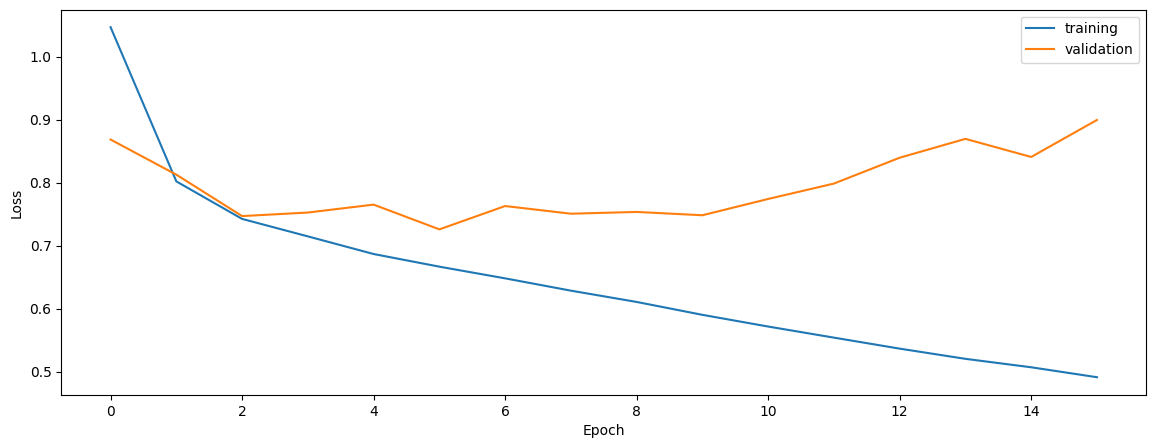

In [6]:
from util import pickleLoad
from visual import plotHistory

history = pickleLoad(path+'/{}.pkl'.format(HASHID))
plotHistory(history)

In [7]:
from util import getPearson, predictInBatches

train_pred = predictInBatches(model,train[0],architecture['batch_size'])
val_pred = predictInBatches(model,val[0],architecture['batch_size'])
test_pred = predictInBatches(model,test[0],architecture['batch_size'])

print('train')
print(getPearson(train[1],train_pred))
print(getPearson(val[1],val_pred))
print(getPearson(test[1],test_pred))

train
0.7624642135181872
0.7437956956858732
0.7494080578444402


In [8]:
print('normalized')
print(getPearson(train[1],train_pred))
print(getPearson(val[1],val_pred))
print(getPearson(test[1],test_pred))

normalized


0.7624642135181872
0.7437956956858732
0.7494080578444402


In [9]:
print('native')
print(getPearson(train[1][train[2]],train_pred[train[2]]))
print(getPearson(val[1][val[2]],val_pred[val[2]]))
print(getPearson(test[1][test[2]],test_pred[test[2]]))

native


0.7609227279258948
0.7545148643620022
0.752637374111075


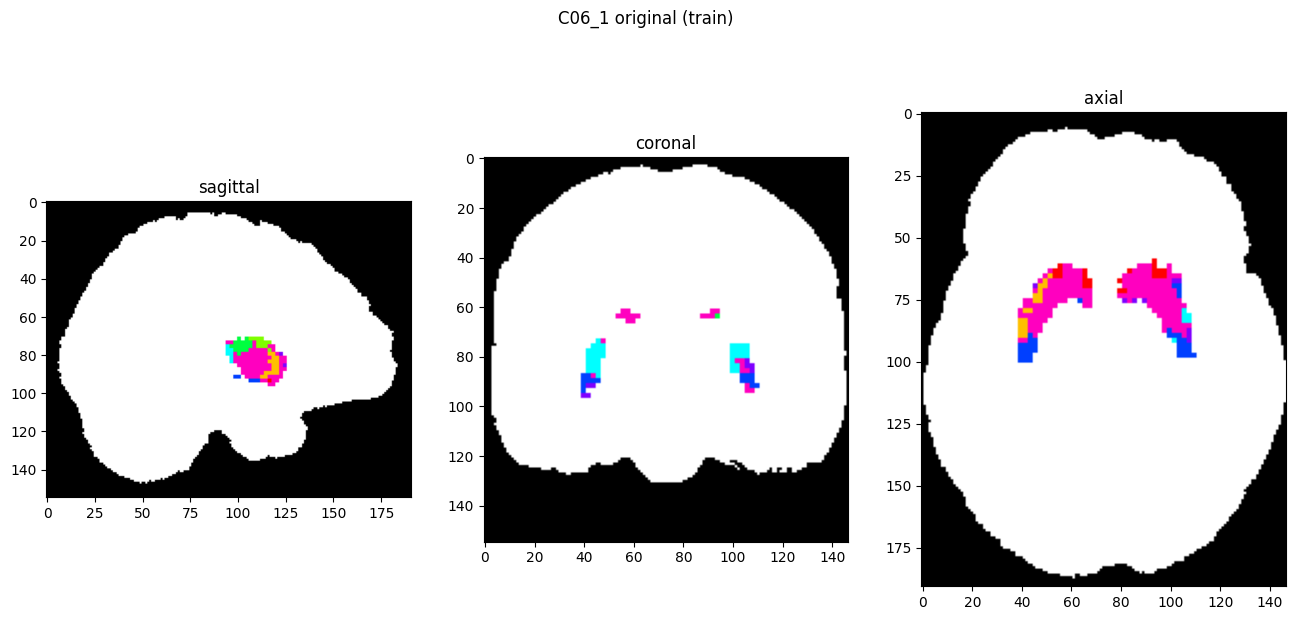

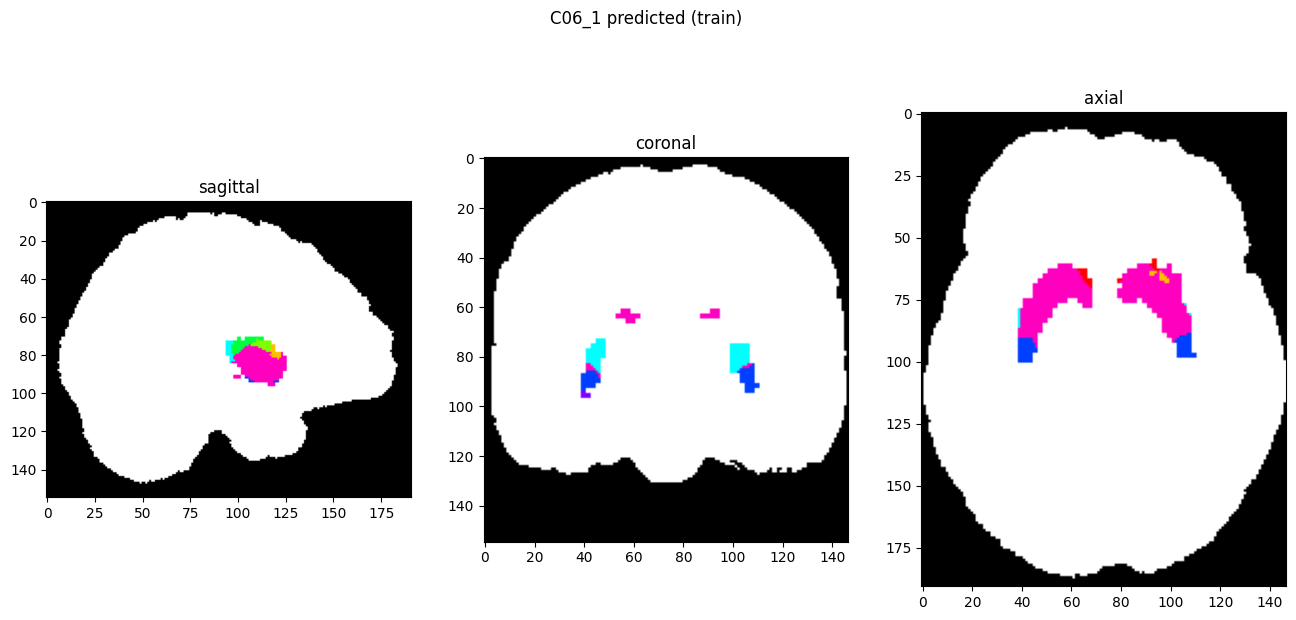

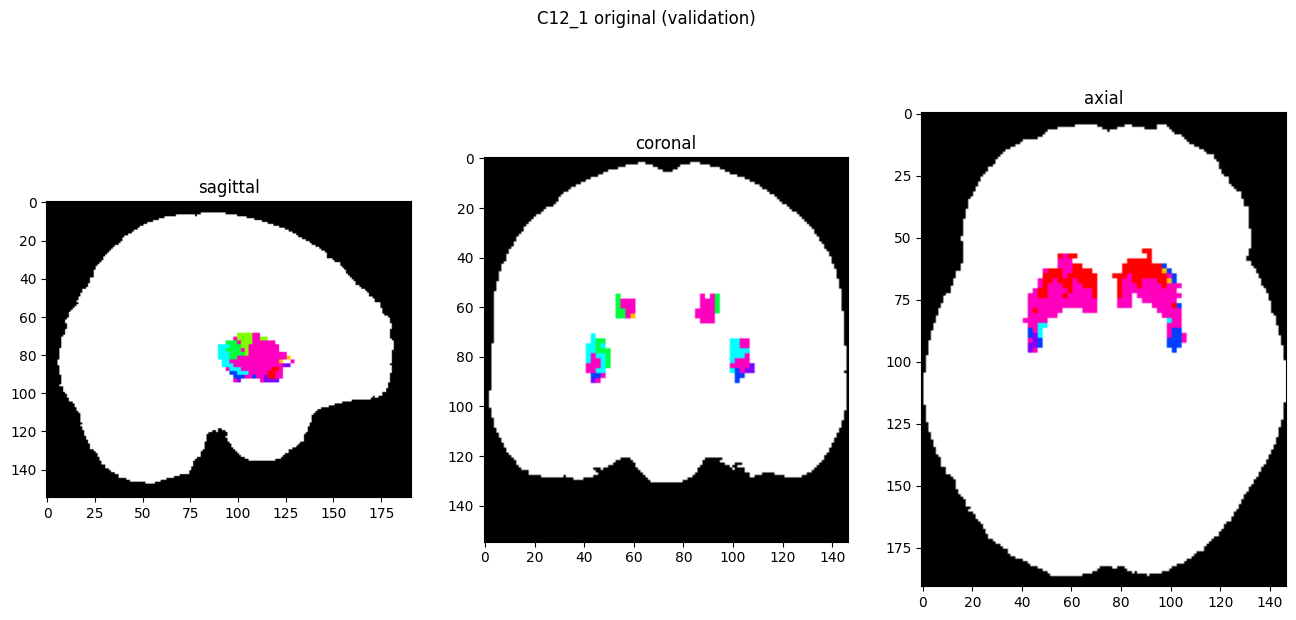

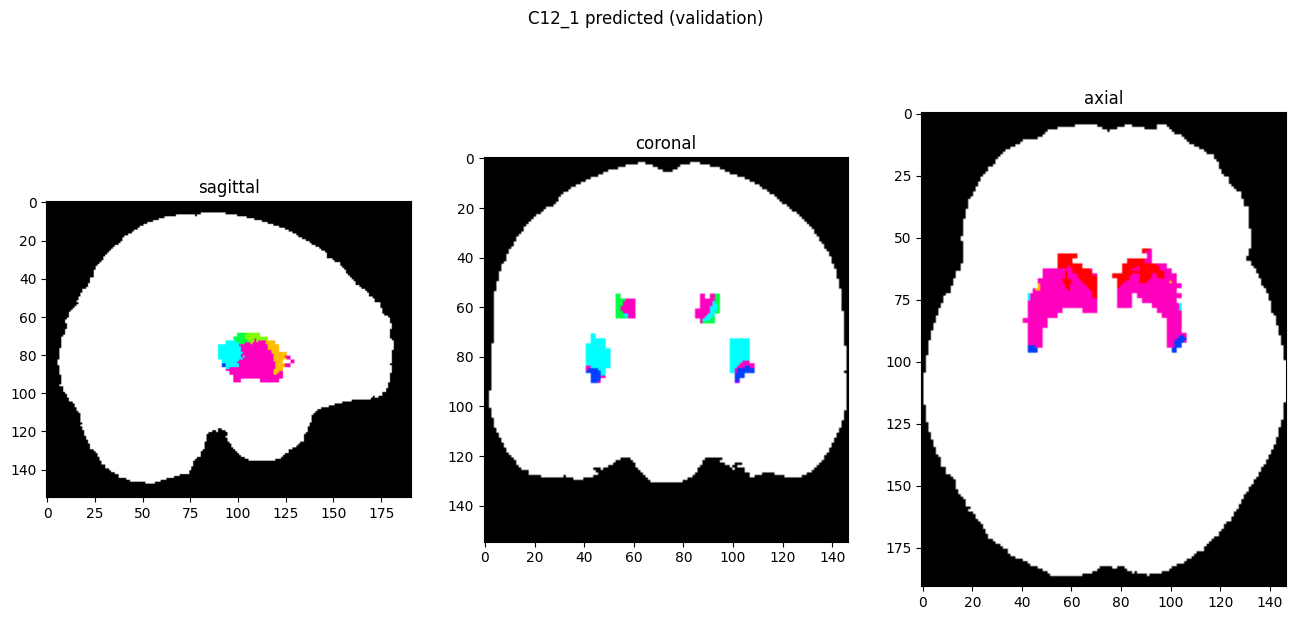

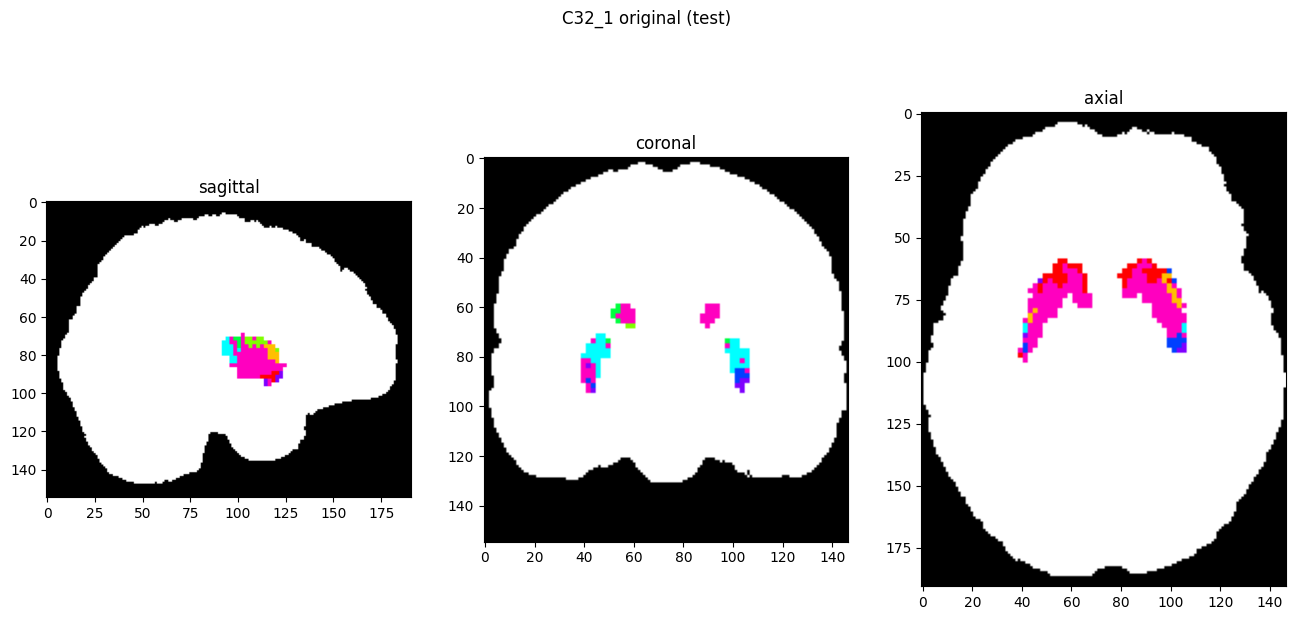

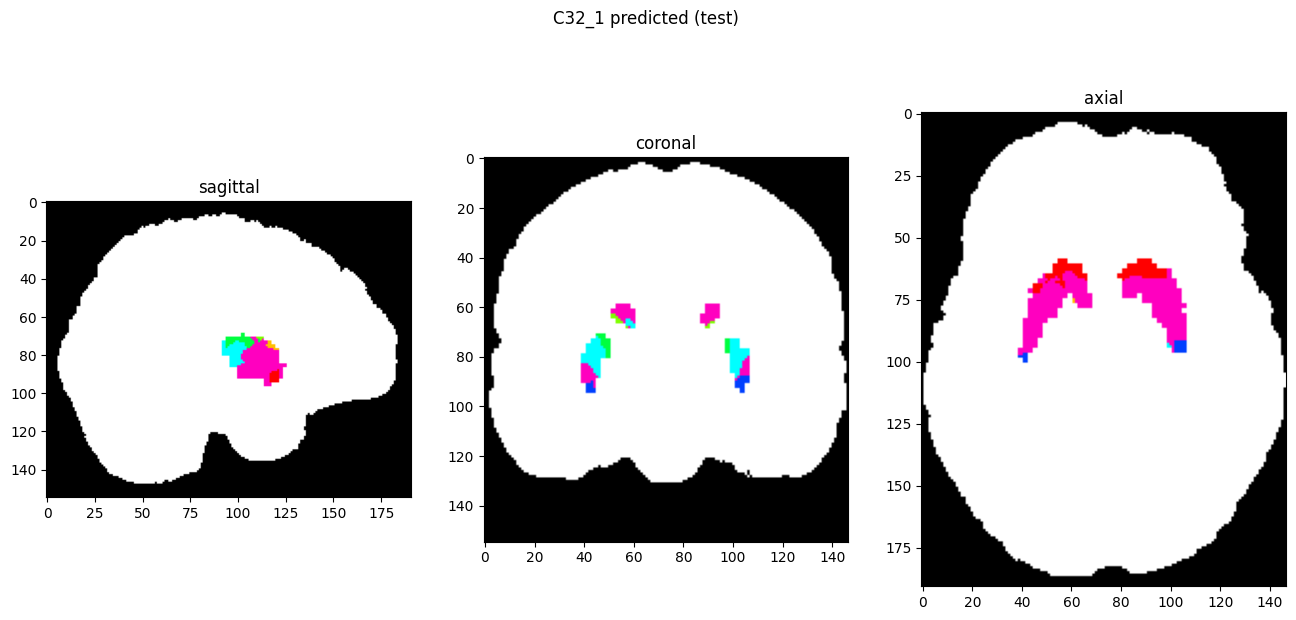

In [10]:
showResults(model, gen, threshold=0)